In [1]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from scipy import interpolate
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata
from lvmdrp.utils import metadata as md
from lvmdrp import config, log, path, __version__ as drpver

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

In [3]:
metadata = md.get_metadata(kind="raw", tileid=1111, mjd=60115, expnum=912).sort_values(["camera", "expnum"])
metadata

[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/raw_metadata.hdf5
[INFO]: found 387 frames in store '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/raw_metadata.hdf5'
[INFO]: filtering by expnum = 912
[INFO]: number of frames after filtering 9
[INFO]: total number of frames found 9


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
3,s,1111,60115,60114,flat,sp1,b1,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b1-00000912.fits
4,s,1111,60115,60114,flat,sp2,b2,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b2-00000912.fits
6,s,1111,60115,60114,flat,sp3,b3,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-b3-00000912.fits
7,s,1111,60115,60114,flat,sp1,r1,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r1-00000912.fits
8,s,1111,60115,60114,flat,sp2,r2,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r2-00000912.fits
2,s,1111,60115,60114,flat,sp3,r3,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-r3-00000912.fits
0,s,1111,60115,60114,flat,sp1,z1,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z1-00000912.fits
5,s,1111,60115,60114,flat,sp2,z2,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z2-00000912.fits
1,s,1111,60115,60114,flat,sp3,z3,912,30.0,False,...,False,False,False,True,excellent,0,1,0,0,sdR-s-z3-00000912.fits


In [4]:
analogs, cpaths, mpaths = md.get_analog_groups(tileid=1111, mjd=60115, imagetyp="bias")

[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/raw_metadata.hdf5
[INFO]: found 387 frames in store
[INFO]: filtering by tileid = 1111
[INFO]: filtering by mjd = 60115
[INFO]: filtering by imagetyp = 'bias'
[INFO]: final number of frames after filtering 90
[INFO]: grouping analogs
[INFO]: found 9 groups of analogs:
[INFO]: (1111, 60115, 'bias', 'b1')
[INFO]: (1111, 60115, 'bias', 'b2')
[INFO]: (1111, 60115, 'bias', 'b3')
[INFO]: (1111, 60115, 'bias', 'r1')
[INFO]: (1111, 60115, 'bias', 'r2')
[INFO]: (1111, 60115, 'bias', 'r3')
[INFO]: (1111, 60115, 'bias', 'z1')
[INFO]: (1111, 60115, 'bias', 'z2')
[INFO]: (1111, 60115, 'bias', 'z3')


In [5]:
# %%timeit

for i, k in enumerate(analogs):
    imageMethod.create_master_frame(in_images=cpaths[k]+["sghdfsj"], out_image=mpaths[i])
    break

# with masked arrays 25.8 s ± 5.99 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
# with normal arrays 21.4 s ± 2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
# with bottleneck     8.82 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

[WARNING]: dropping 1 missing input paths: '{'sghdfsj'}' for 'in_images' at create_master_frame
[INFO]: input frames: /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/ancillary/lvm-pbias-b1-00000940.fits,/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/ancillary/lvm-pbias-b1-00000915.fits,/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/ancillary/lvm-pbias-b1-00000913.fits,/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/ancillary/lvm-pbias-b1-00000942.fits,/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/ancillary/lvm-pbias-b1-00000943.fits,/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/a

In [6]:
master_frame = image.Image()
master_frame.loadFitsData(mpaths[0])
master_frame.getIndividualFrames()

TILEID,MJD,EXPNUM,SPEC,CAMERA,EXPTIME
int64,int64,int64,str3,str2,float64
1111,60115,940,sp1,b1,0.0
1111,60114,915,sp1,b1,0.0
1111,60114,913,sp1,b1,0.0
...,...,...,...,...,...
1111,60114,914,sp1,b1,0.0
1111,60115,944,sp1,b1,0.0
1111,60115,941,sp1,b1,0.0


[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'b1'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'b1'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'b1'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 639 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 639


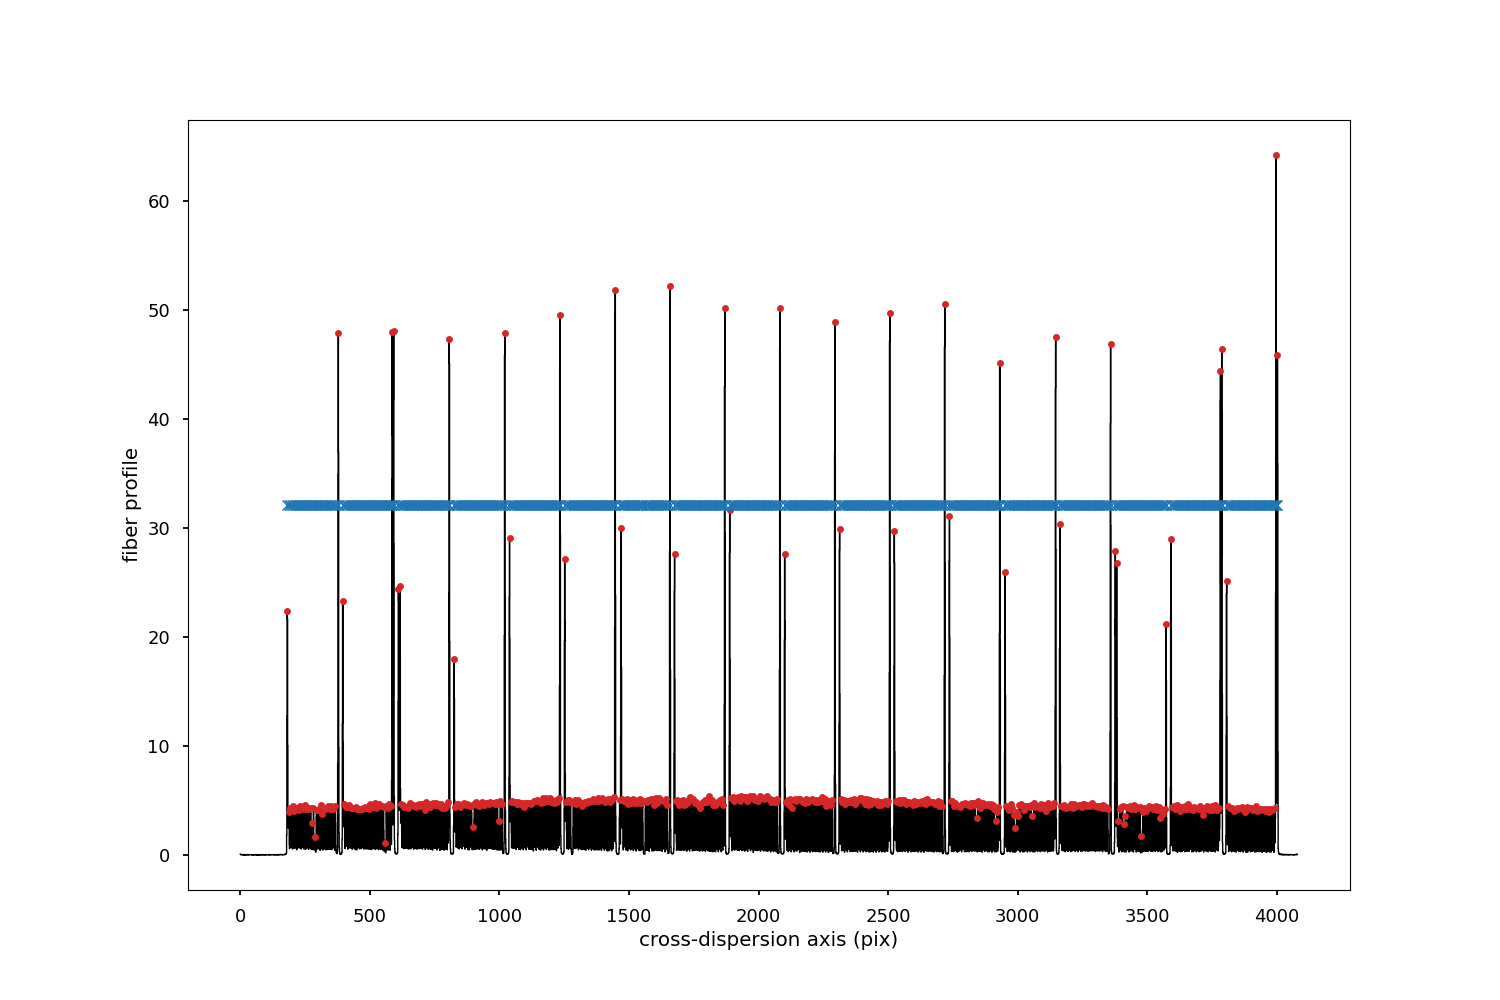

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'b2'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'b2'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'b2'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


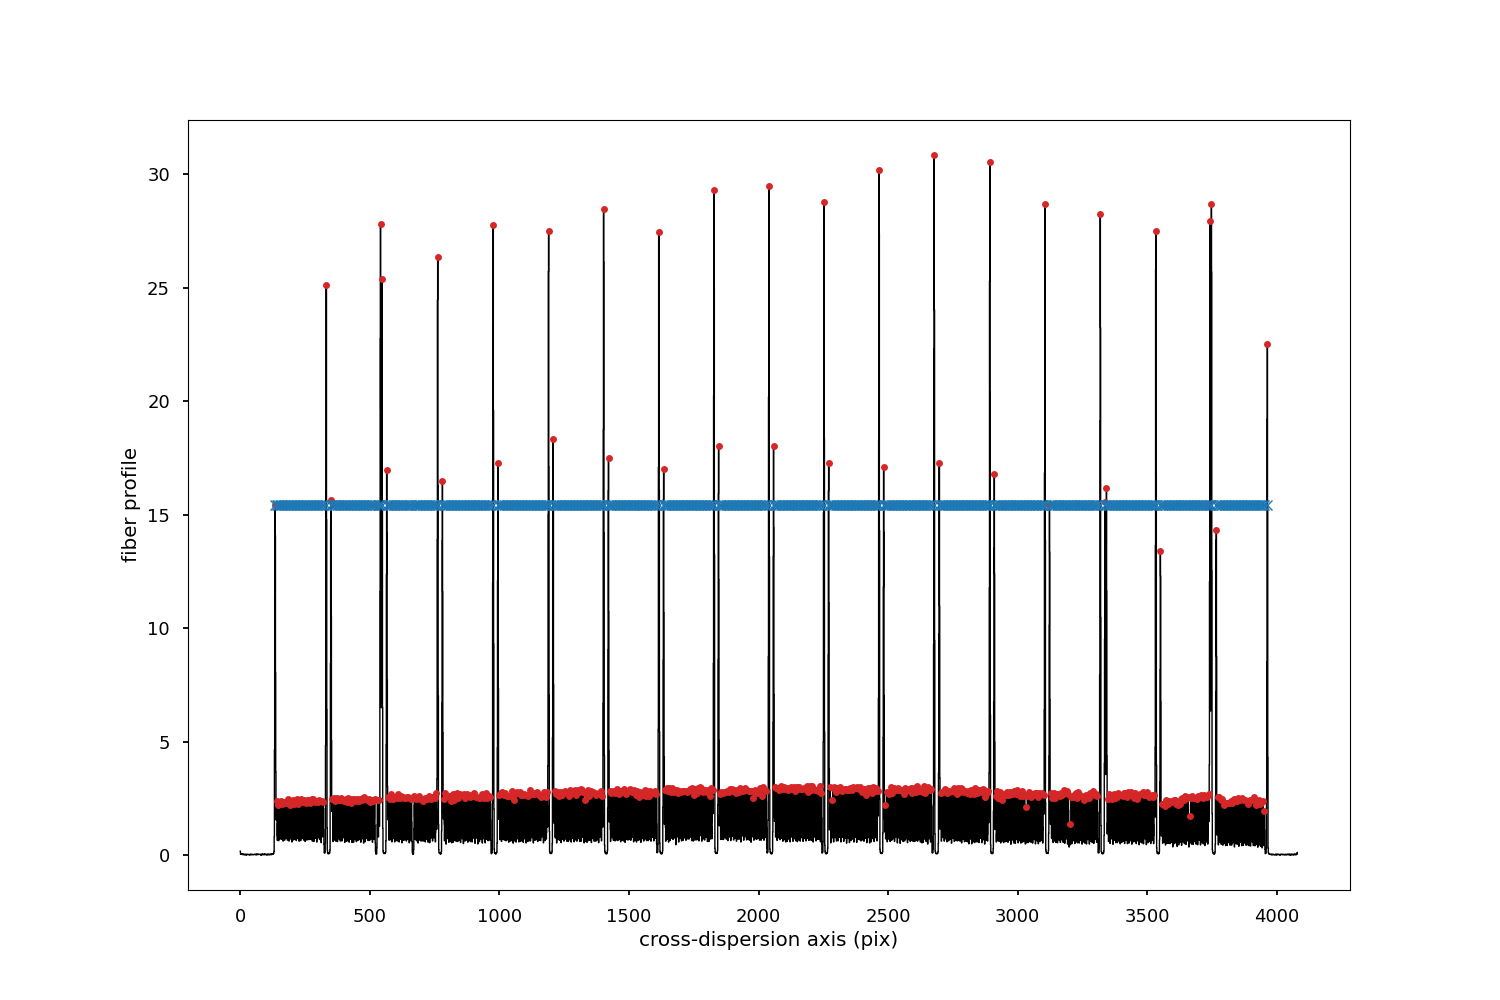

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'b3'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'b3'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'b3'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 635 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 635


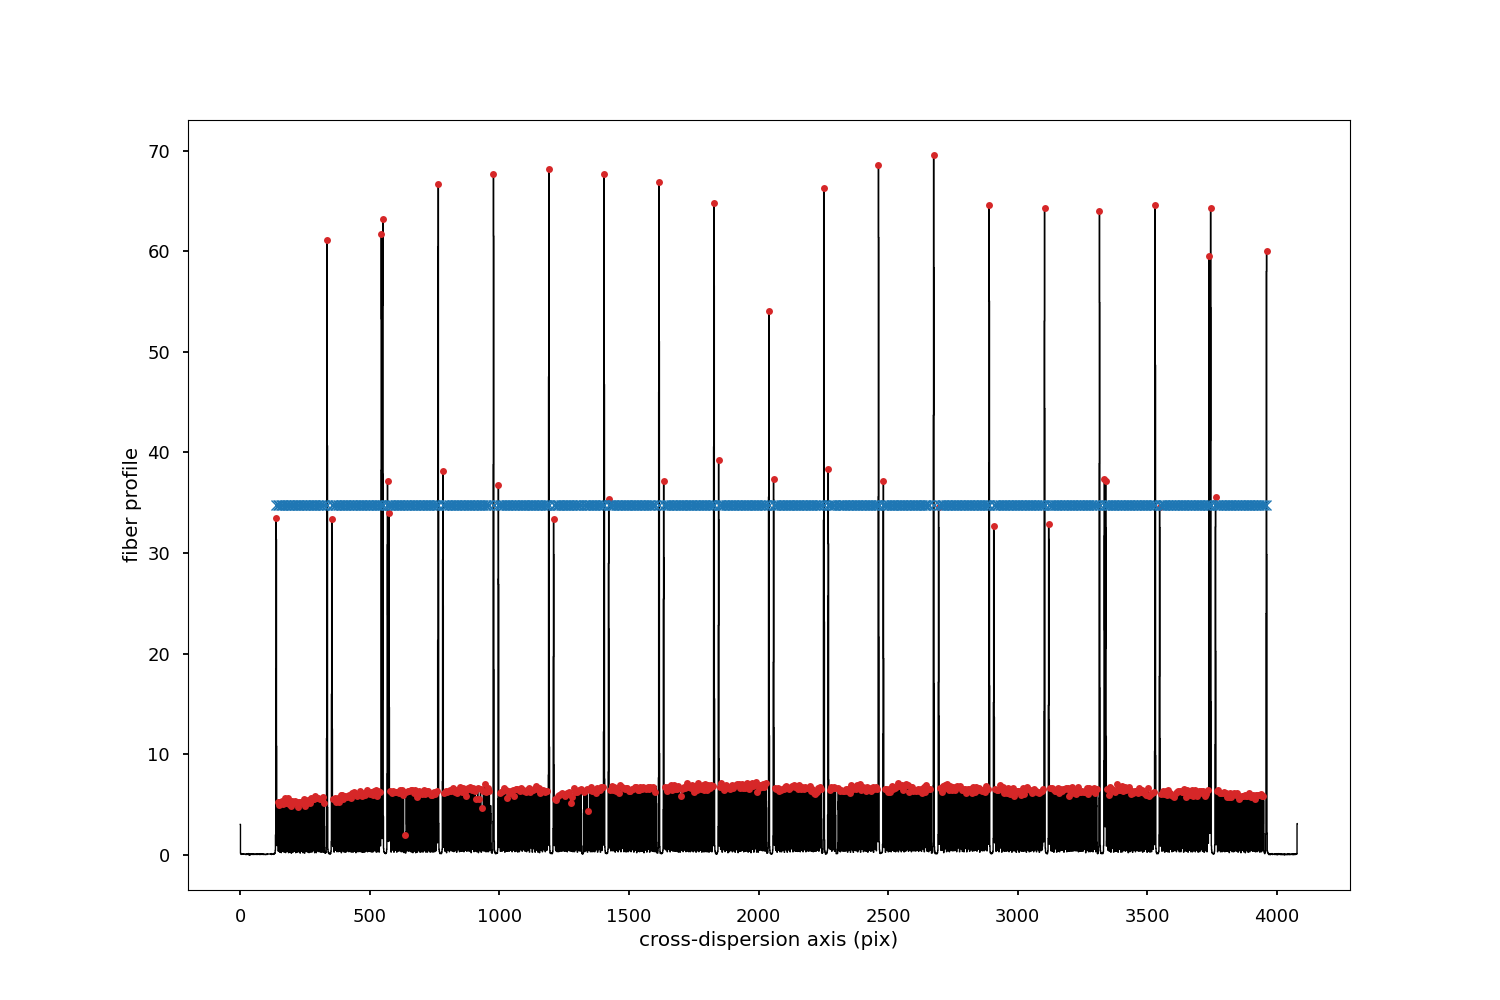

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'r1'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'r1'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'r1'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


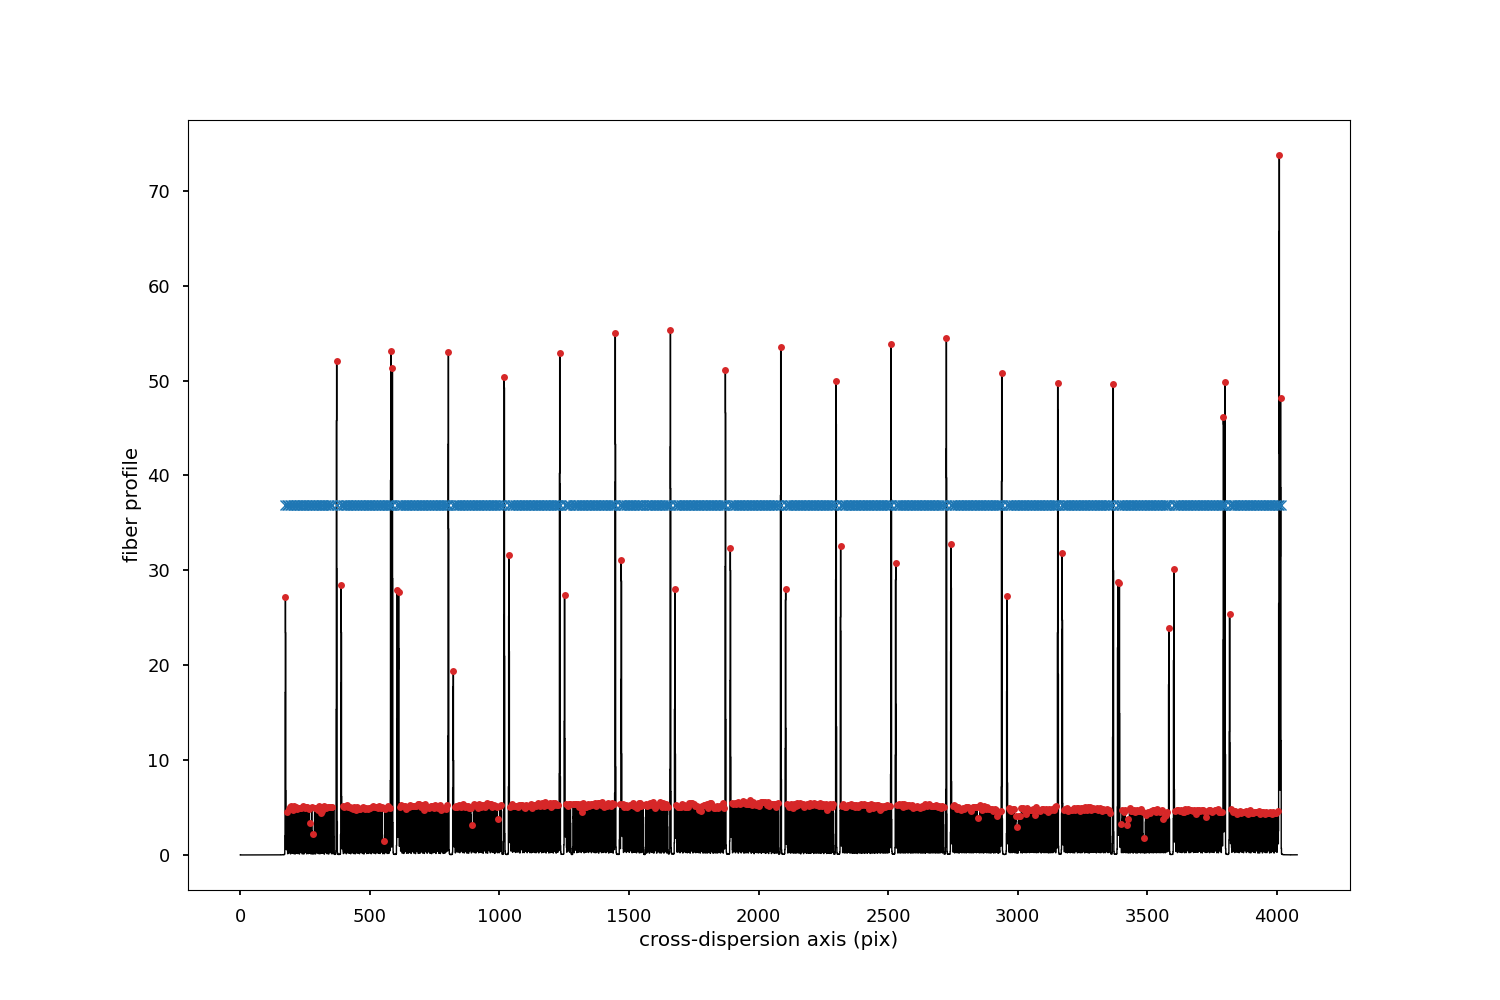

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'r2'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'r2'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'r2'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


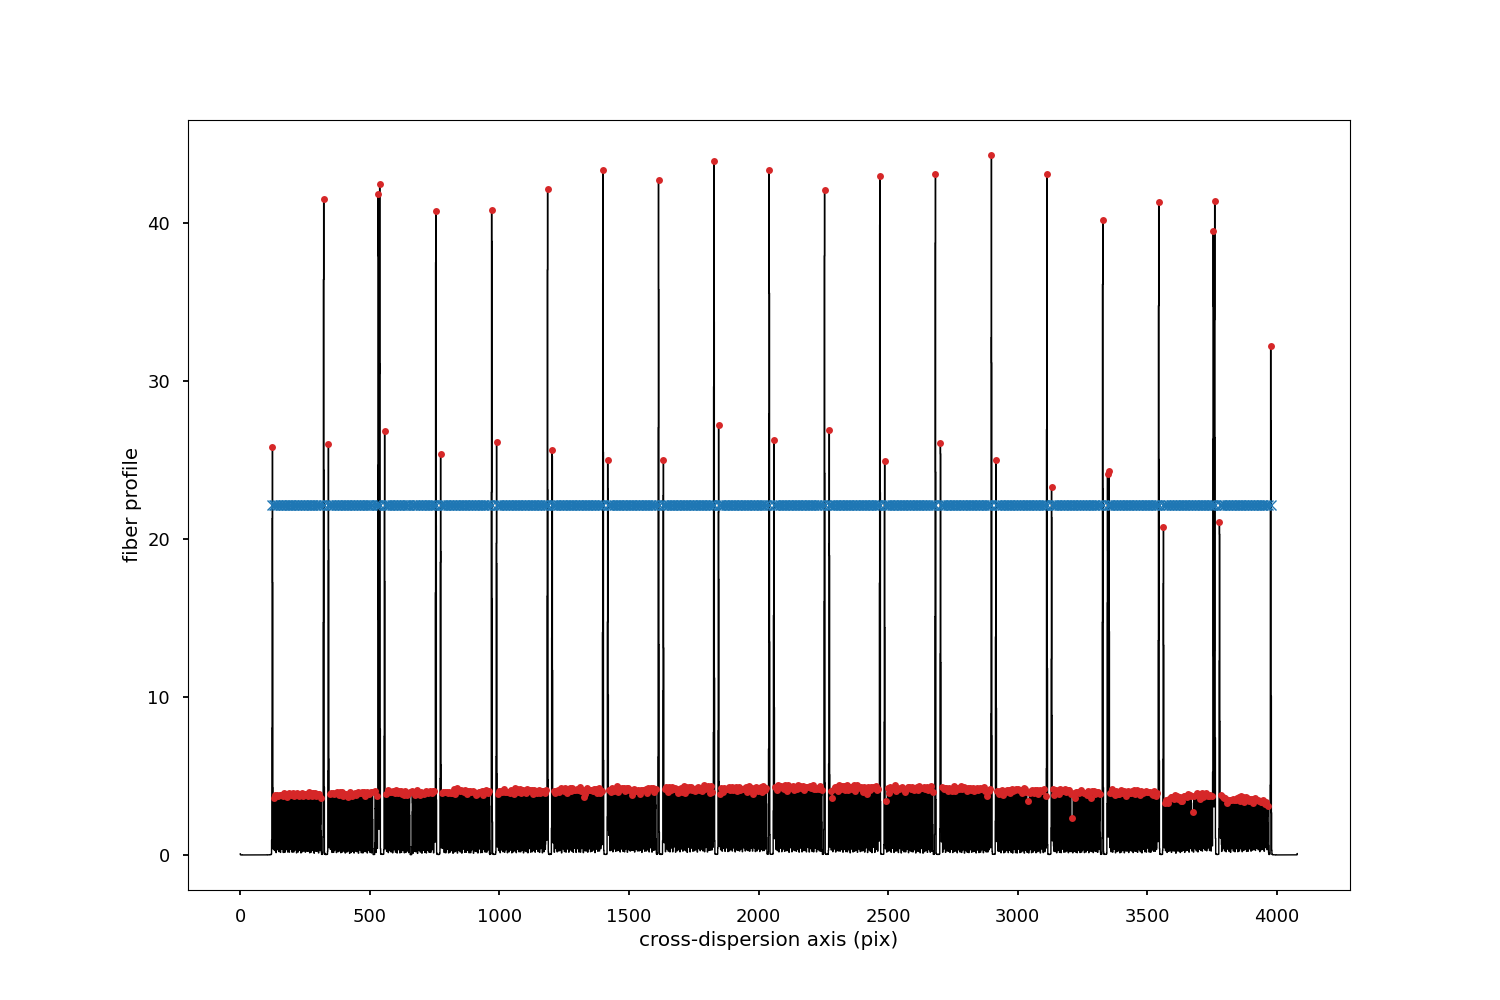

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'r3'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'r3'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'r3'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


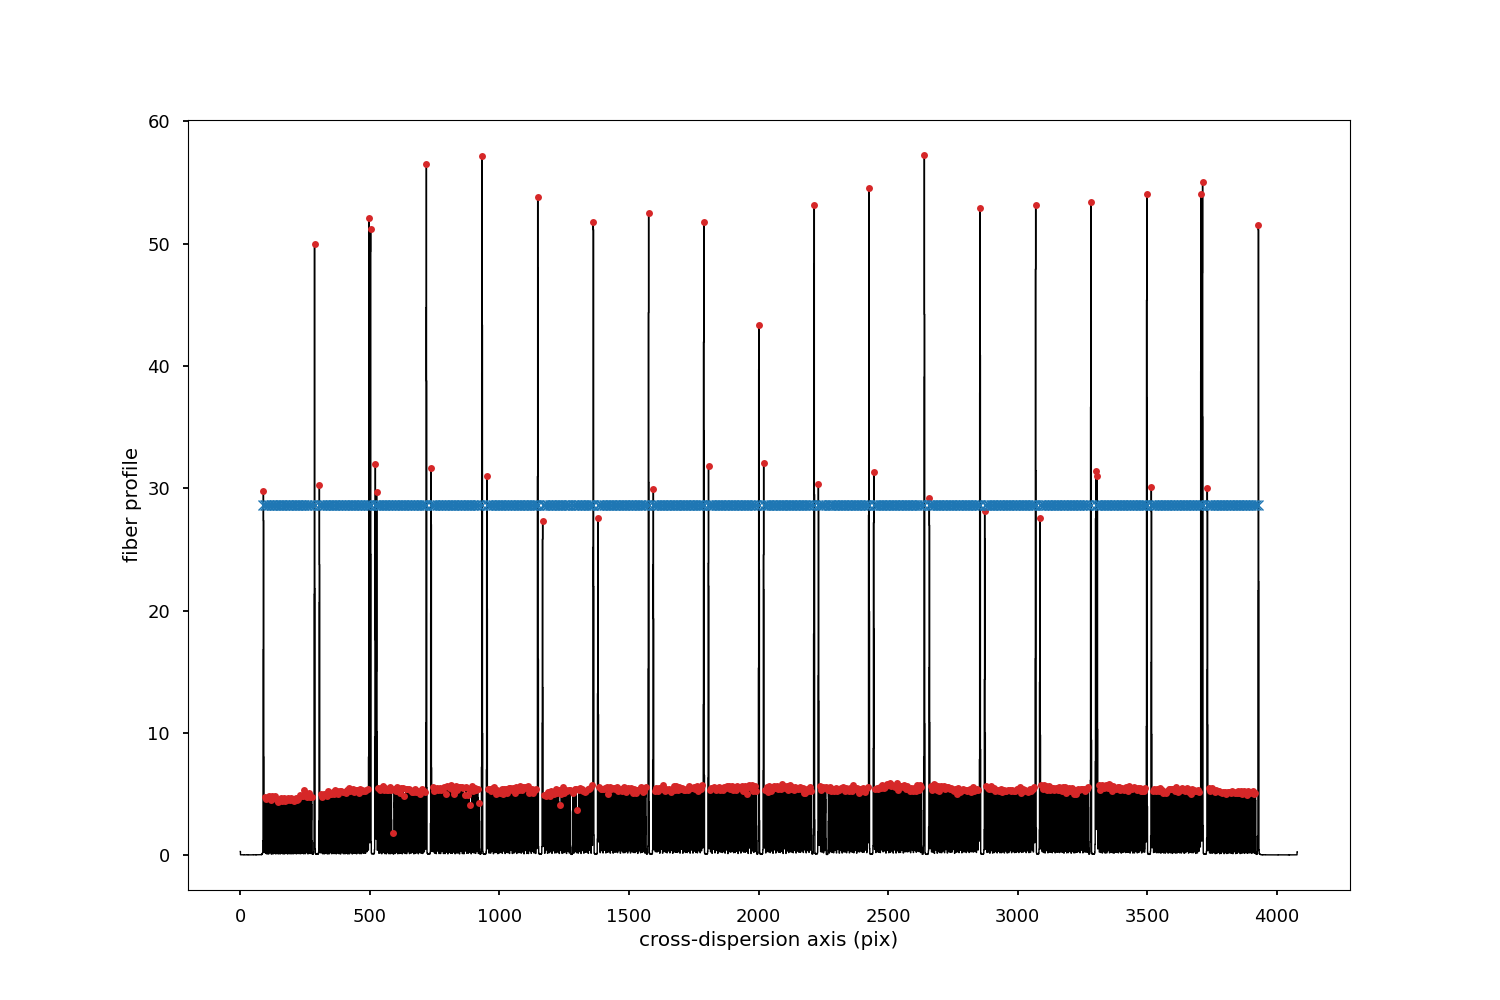

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'z1'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'z1'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'z1'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 630 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 630


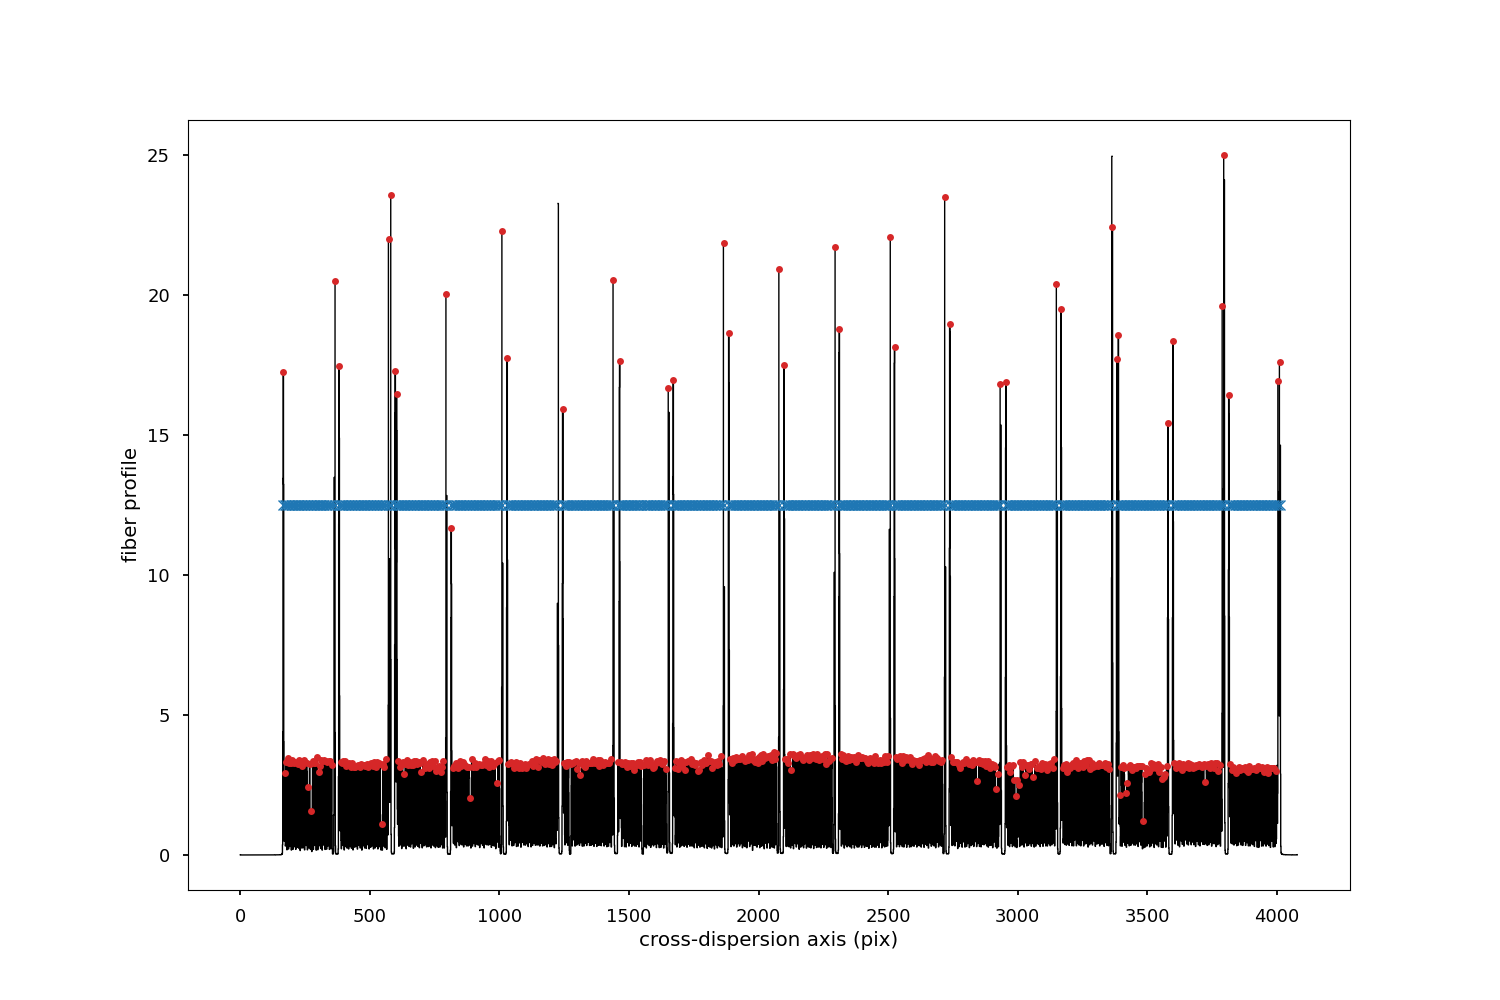

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'z2'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'z2'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'z2'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 635 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 635


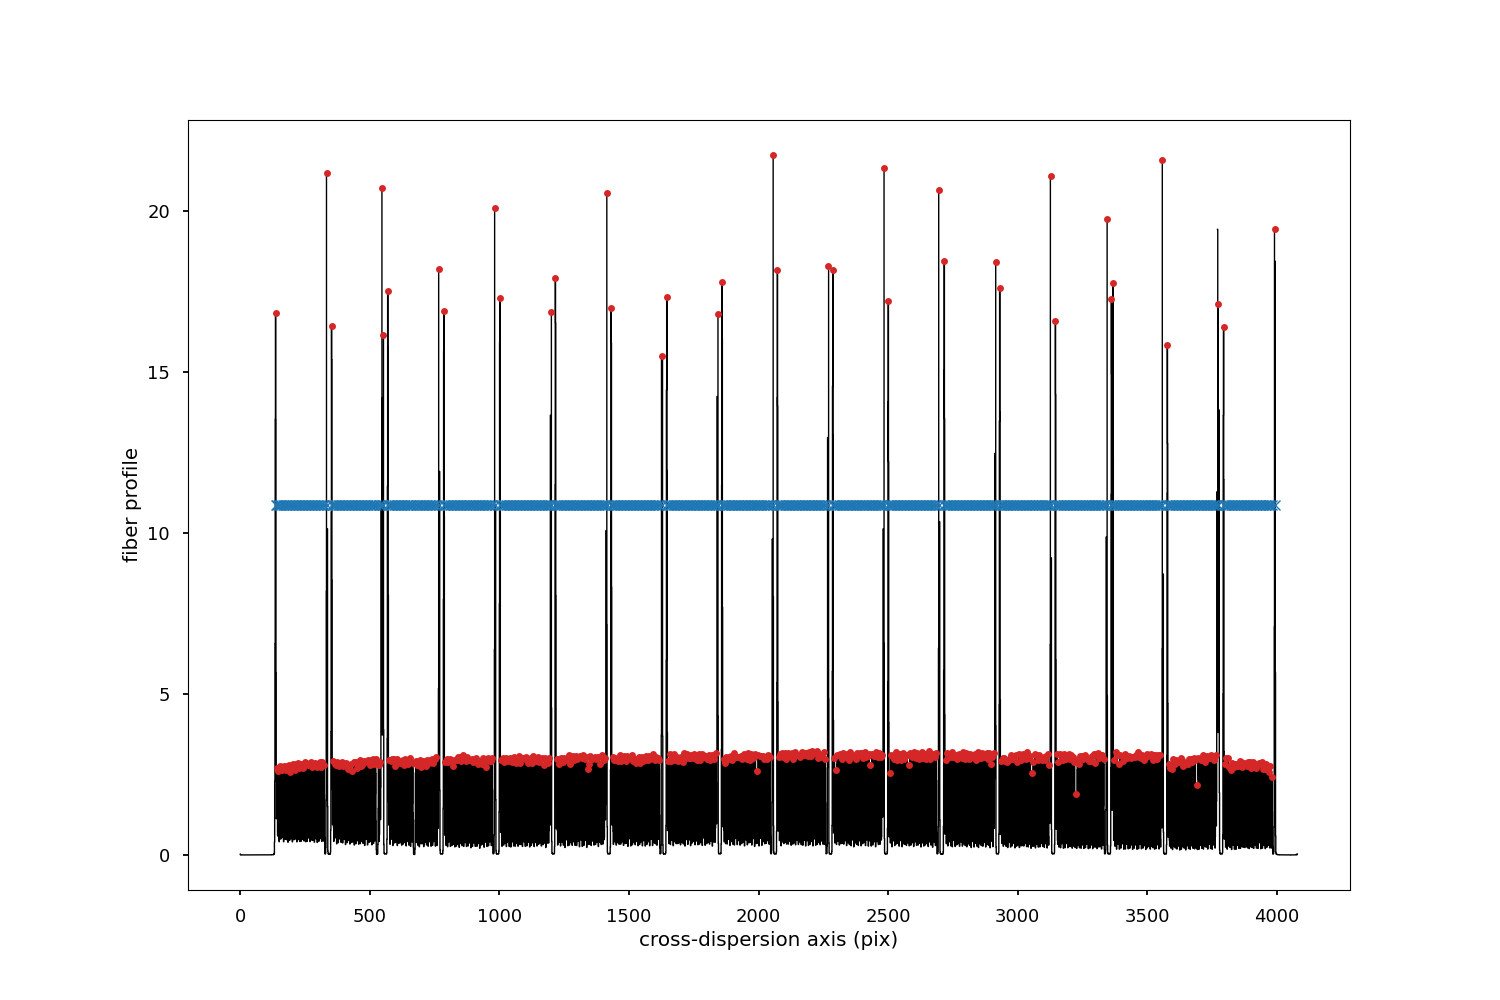

[INFO]: target frame of type 'flat' needs calibration frames: bias, dark, pixelflat
[INFO]: loading metadata store at /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/master_metadata.hdf5
[INFO]: found 18 master frames in store
[INFO]: final number of master frames after filtering 18
[INFO]: filtering by imagetyp = 'bias'
[INFO]: filtering by camera = 'z3'
[INFO]: found master bias
[INFO]: filtering by imagetyp = 'dark'
[INFO]: filtering by camera = 'z3'
[INFO]: found master dark
[INFO]: filtering by imagetyp = 'pixelflat'
[INFO]: filtering by camera = 'z3'
[WARNING]: no master pixelflat frame found
[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


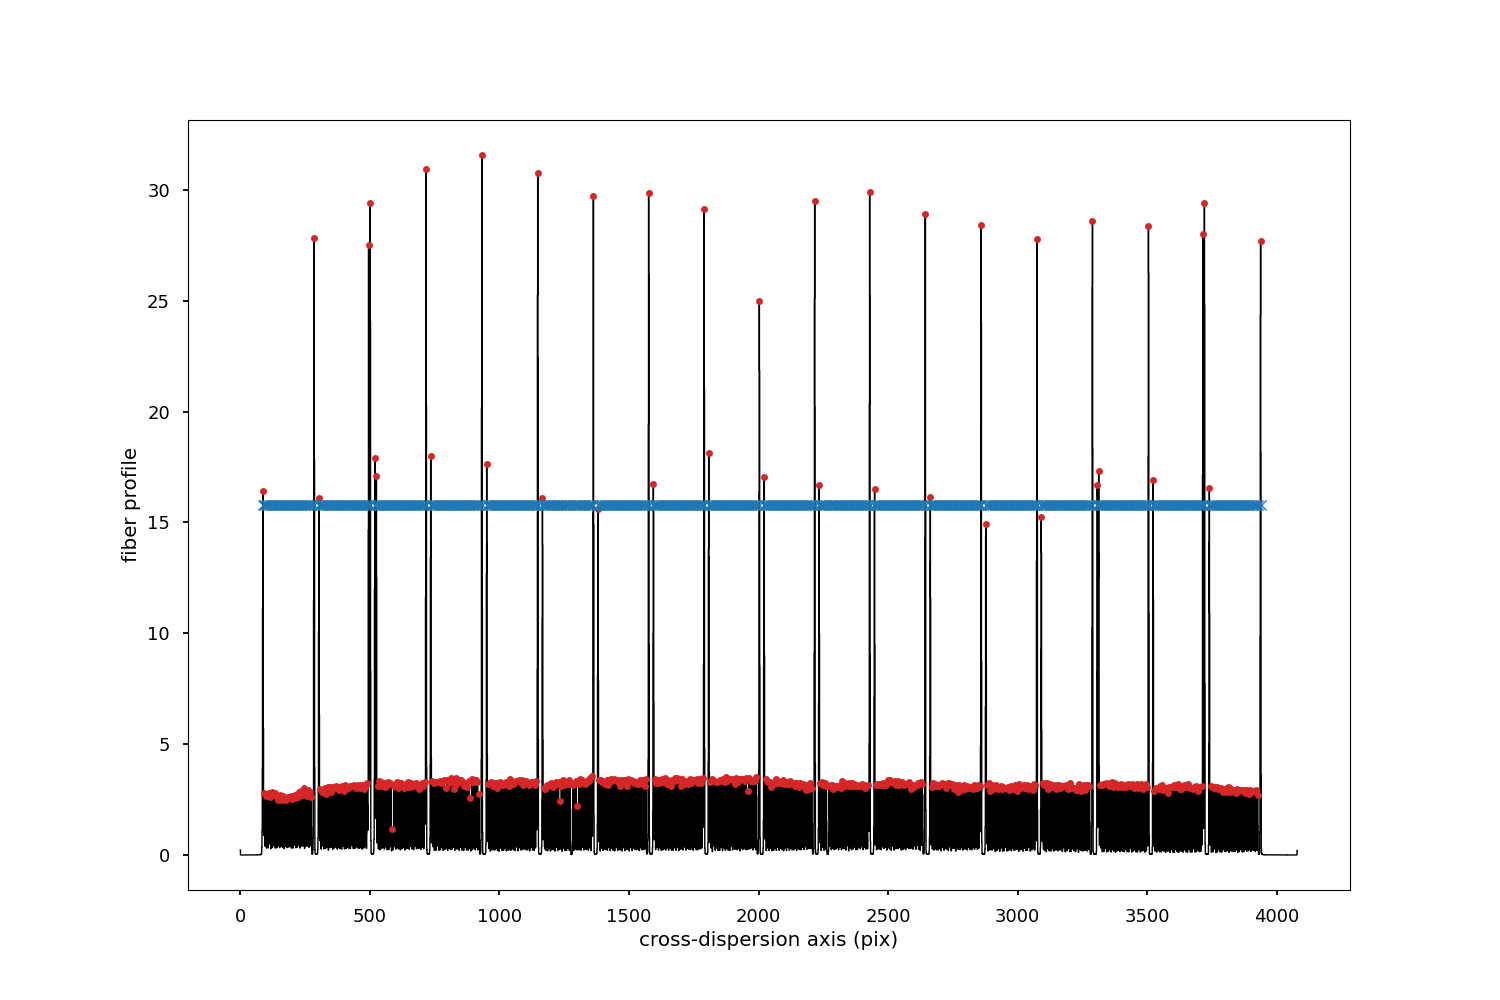

In [6]:
for _, row in metadata.iterrows():
    masters_cal = md.match_master_metadata(target_imagetyp=row.imagetyp, target_camera=row.camera)
    bias, dark = masters_cal["bias"], masters_cal["dark"]
    mbias_path = path.full("lvm_cal_mbias", drpver=drpver, tileid=bias.tileid, mjd=bias.mjd, camera=bias.camera)
    mdark_path = path.full("lvm_cal_time", drpver=drpver, tileid=dark.tileid, mjd=dark.mjd, camera=dark.camera, exptime=dark.exptime, kind="mdark")
    
    raw_path = path.full("lvm_raw", hemi="s", mjd=row.mjd, camspec=row.camera, expnum=row.expnum)
    pre_path = path.full("lvm_anc", drpver=drpver, hemi="s", tileid=row.tileid, mjd=row.mjd, camera=row.camera, expnum=row.expnum, imagetype=row.imagetyp, kind="p")
    cal_path = path.full("lvm_anc", drpver=drpver, hemi="s", tileid=row.tileid, mjd=row.mjd, camera=row.camera, expnum=row.expnum, imagetype=row.imagetyp, kind="c")
    pks_path = path.full("lvm_cal", drpver=drpver, hemi="s", tileid=row.tileid, mjd=row.mjd, camera=row.camera, expnum=row.expnum, kind="peaks", ext="txt")
    
    # imageMethod.preproc_raw_frame(raw_path, pre_path)
    # imageMethod.detrend_frame(pre_path, cal_path)
    imageMethod.find_peaks_auto(cal_path, pks_path, slice=2000, display_plots=True)

[INFO]: selecting column = 2000 to locate fibers
[INFO]: locating fibers
[INFO]: found 651 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 651
[INFO]: writing peaks_test.fits


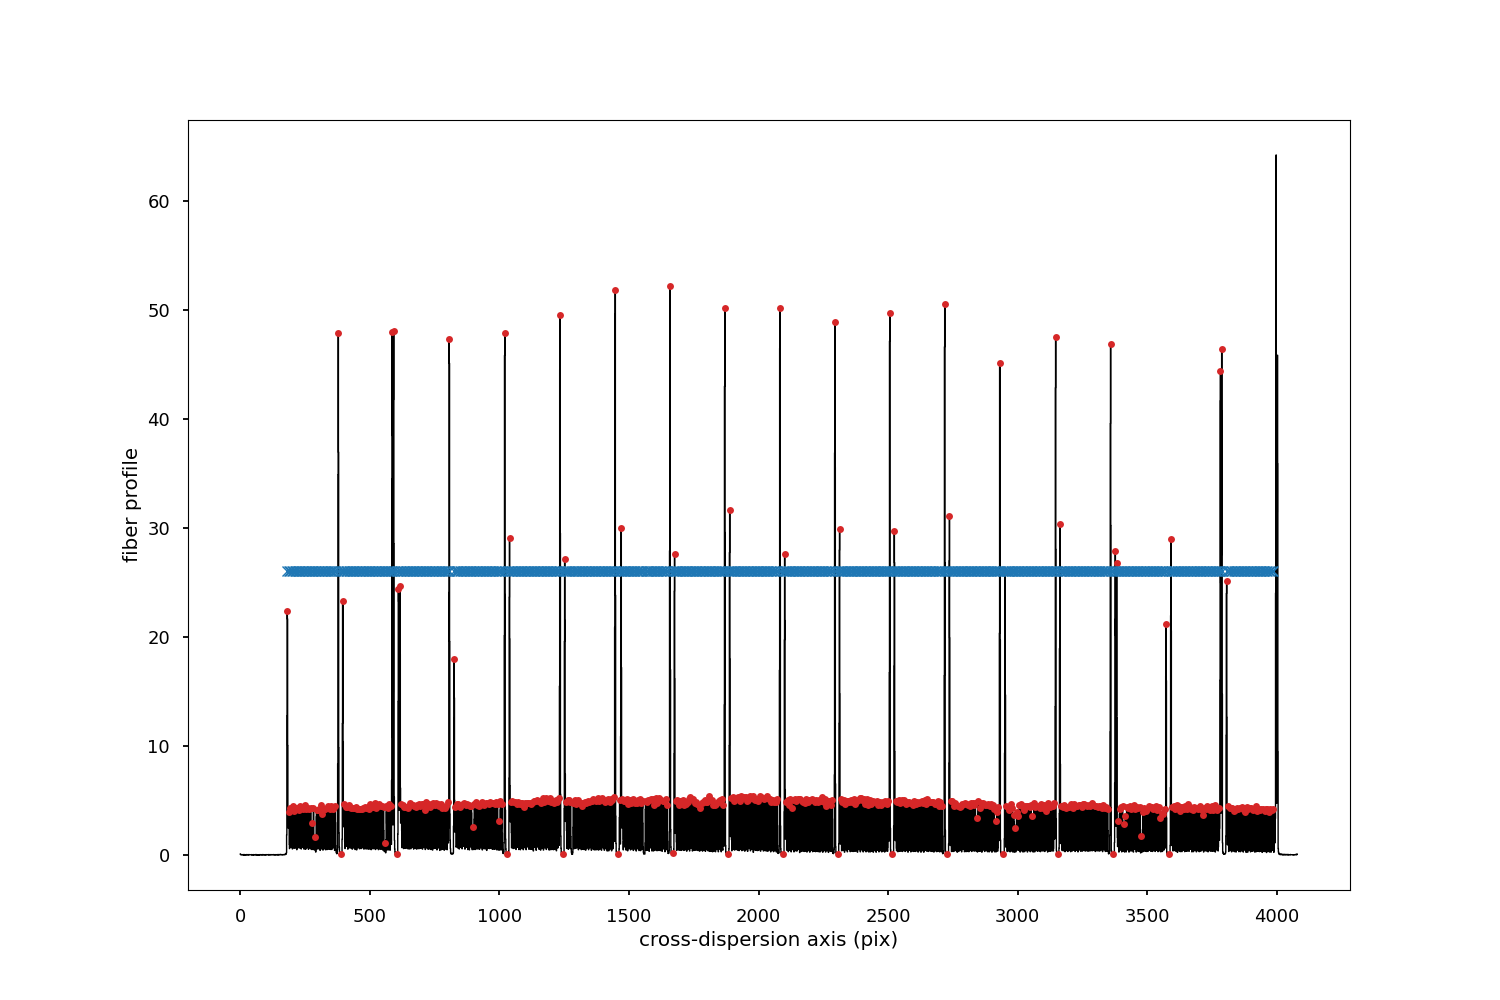

[INFO]: tracing fibers along dispersion axis
tracing fiber right from pixel 2000: 100%|########################################################| 2085/2085 [00:02<00:00, 982.46pixel/s]
[INFO]: fitting trace with 6-deg polynomial
[INFO]: Fitting "poly" class of polynomial.
[WARNING]: divide by zero encountered in scalar divide (RuntimeWarning)
[WARNING]: divide by zero encountered in scalar divide (RuntimeWarning)
[WARNING]: invalid value encountered in add (RuntimeWarning)
[ERROR]: Fiber trace failure at fiber 1: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 2: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 3: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 4: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 5: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 6: SVD did not converge in Linear Least Squares
[ERROR]

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

[ERROR]: Fiber trace failure at fiber 211: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 212: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 213: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 217: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 220: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 221: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 222: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 223: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 224: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 225: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 226: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

[ERROR]: Fiber trace failure at fiber 330: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 331: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 332: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 333: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 334: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 335: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 336: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 337: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 338: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 339: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 340: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

[ERROR]: Fiber trace failure at fiber 441: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 442: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 443: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 444: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 445: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 446: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 447: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 448: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 449: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 450: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 451: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

[ERROR]: Fiber trace failure at fiber 573: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 574: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 575: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 576: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 577: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 578: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 579: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 585: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 586: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 587: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 588: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at 

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

[ERROR]: Fiber trace failure at fiber 647: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 648: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 649: SVD did not converge in Linear Least Squares
[ERROR]: Fiber trace failure at fiber 650: SVD did not converge in Linear Least Squares


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

In [7]:
cam = "b1"

input_fiberflat_path = f"/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/lvm/spectro/redux/0.1.0.dev0/1111/60115/ancillary/lvm-cflat-{cam}-00000912.fits"
output_peaks_path = "peaks_test.fits"

imageMethod.find_peaks_auto(
    in_image=input_fiberflat_path, out_peaks=output_peaks_path,
    pixel_range=[10, 4000], fibers_dmin=5, threshold=0.08, slice=2000, median_box=[1, 10],
    display_plots=True)

imageMethod.trace_peaks(input_fiberflat_path, in_peaks=output_peaks_path, out_trace="trace_test.fits", poly_disp=6, threshold=20)

In [37]:
x = fits.open("peaks_test.fits", ignore_missing_simple=True)
x[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   14 / length of dimension 1                          
NAXIS2  =                  651 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'FIBER   '                                                            
TFORM1  = 'I       '                                                            
TTYPE2  = 'PIXEL   '                                                            
TFORM2  = 'I       '                                                            
TTYPE3  = 'SUBPIX  '        

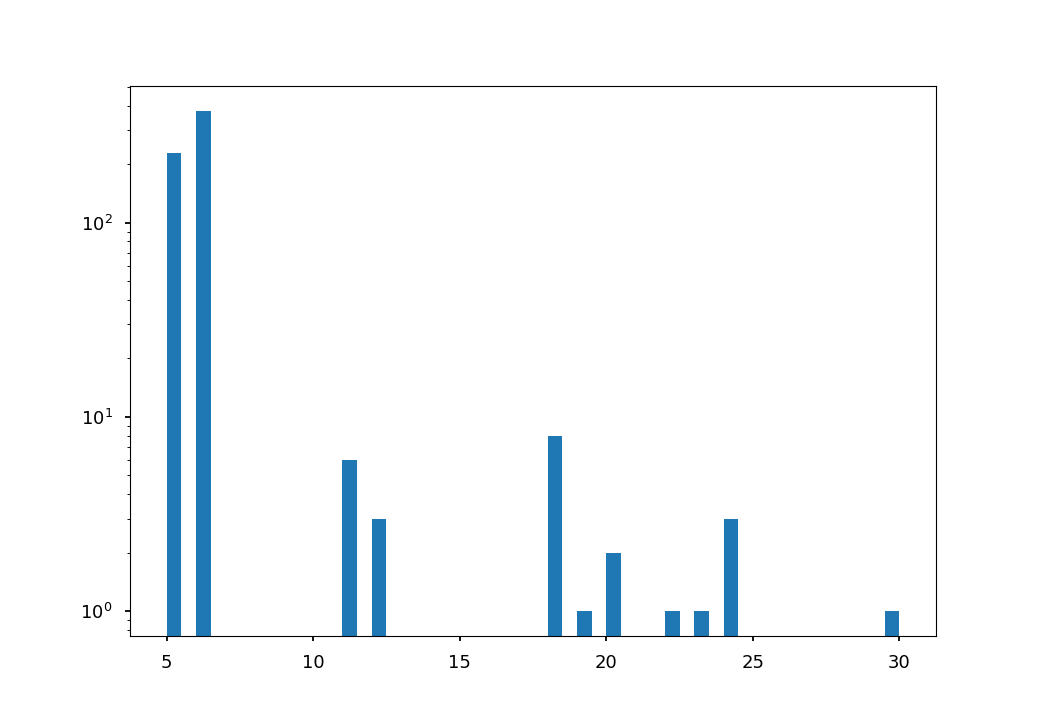

In [7]:
_, obs_fibers, _, _ = np.genfromtxt(output_peaks_path, skip_header=1, dtype=[int, int, float, bool], unpack=True)

pixels = np.arange(4080)
obs_profile = np.zeros_like(pixels)
obs_profile[obs_fibers] = 1

plt.figure()
plt.hist(np.diff(obs_fibers), bins=50)
plt.gca().set_yscale("log")

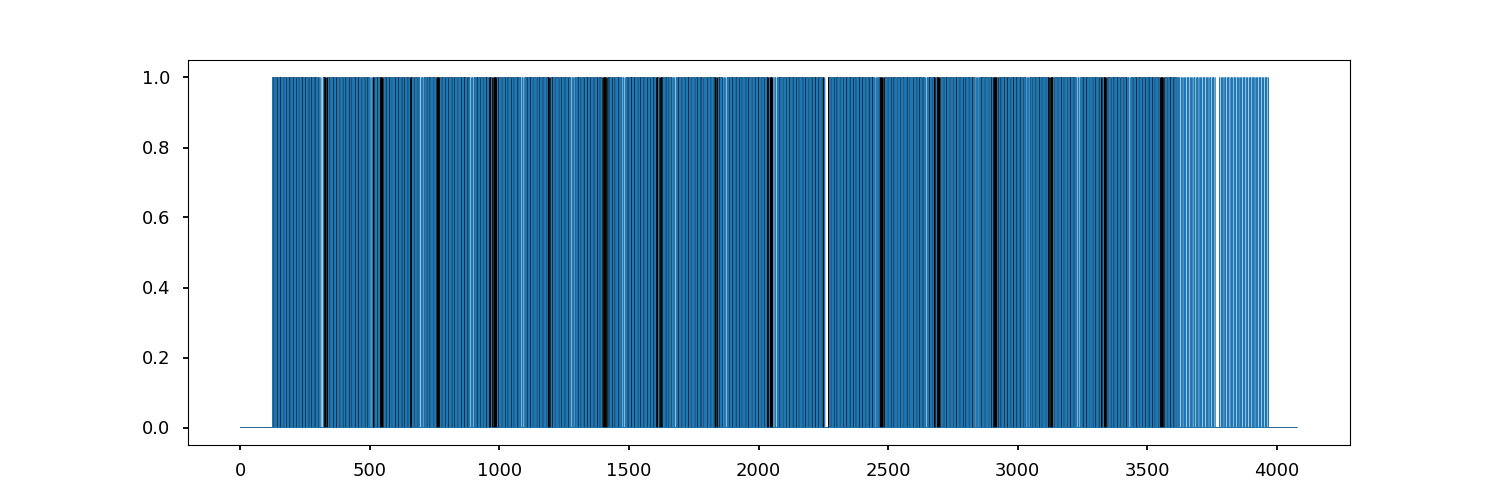

In [8]:
ref_sep = 5
ref_block = np.arange(0, ref_sep*36, ref_sep)
ref_block

ref_gap = 20
ref_dif = 125
nblocks = 18

ref_fibers = np.asarray([(ref_dif + i*(ref_block.max()+ref_gap)) + ref_block for i in range(nblocks)]).flatten()
ref_fibers

ref_profile = np.zeros_like(pixels)
ref_profile[ref_fibers] = 1

plt.figure(figsize=(15,5))
plt.step(pixels, ref_profile, lw=0.5, color="k", where="mid")
plt.step(pixels, obs_profile, lw=0.5, color="tab:blue", where="mid")


0.3746093259566731 1.1283641820910455 -28


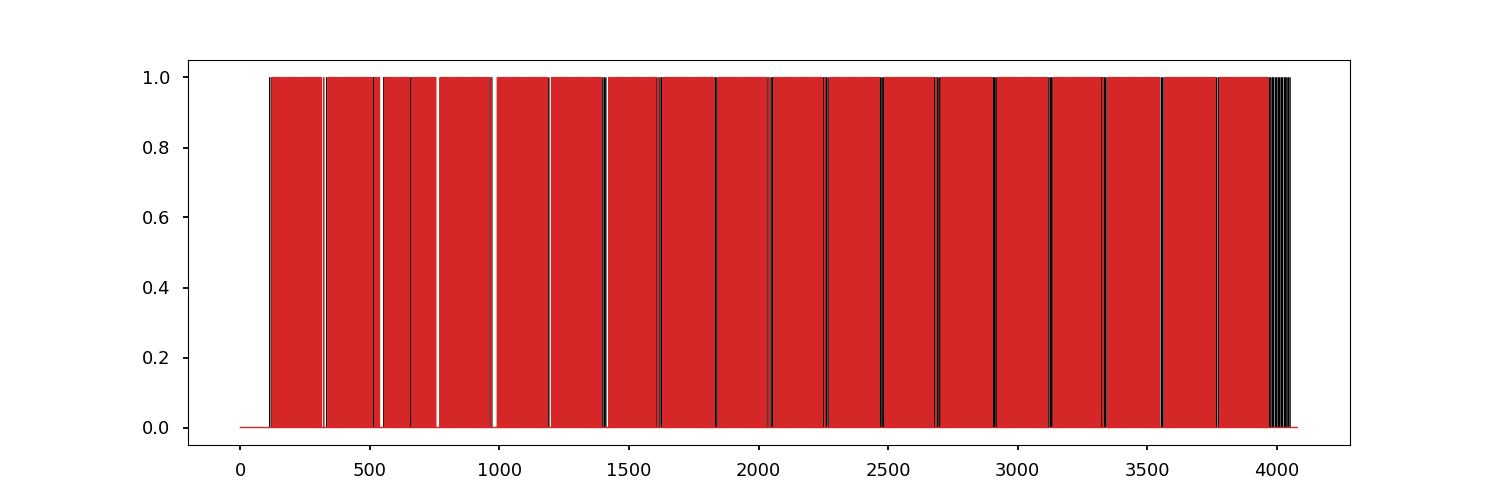

In [9]:
# obs_profile = spectrum1d._apply_shift_and_stretch(ref_profile, shift=10, stretch_factor=0.9)
c, bhat, mhat = spectrum1d._cross_match(ref_profile, obs_profile, stretch_factors=np.linspace(0.8,1.2,2000), shift_range=[-100, 100], peak_num=648)
print(c, mhat, bhat)

plt.figure(figsize=(15,5))
plt.step(pixels, spectrum1d._apply_shift_and_stretch(ref_profile, shift=bhat, stretch_factor=mhat), lw=0.5, color="k", where="mid")
plt.step(pixels, obs_profile, lw=1, color="tab:red")

In [10]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

# get master calibration metadata
masters_fiberflat = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mfiberflat").sort_values("camera")

  0%|                                                                                                                                                                            | 0/4578 [00:02<?, ?files/s]


ValueError: LVMCORE_DIR environment variable not found.  Please set up the repo.

mjd                                         super
kind                                   mfiberflat
camera                                         b1
exptime                                        30
path       ./data/lvm-super-mfiberflat-b1-30.fits
Name: 1, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


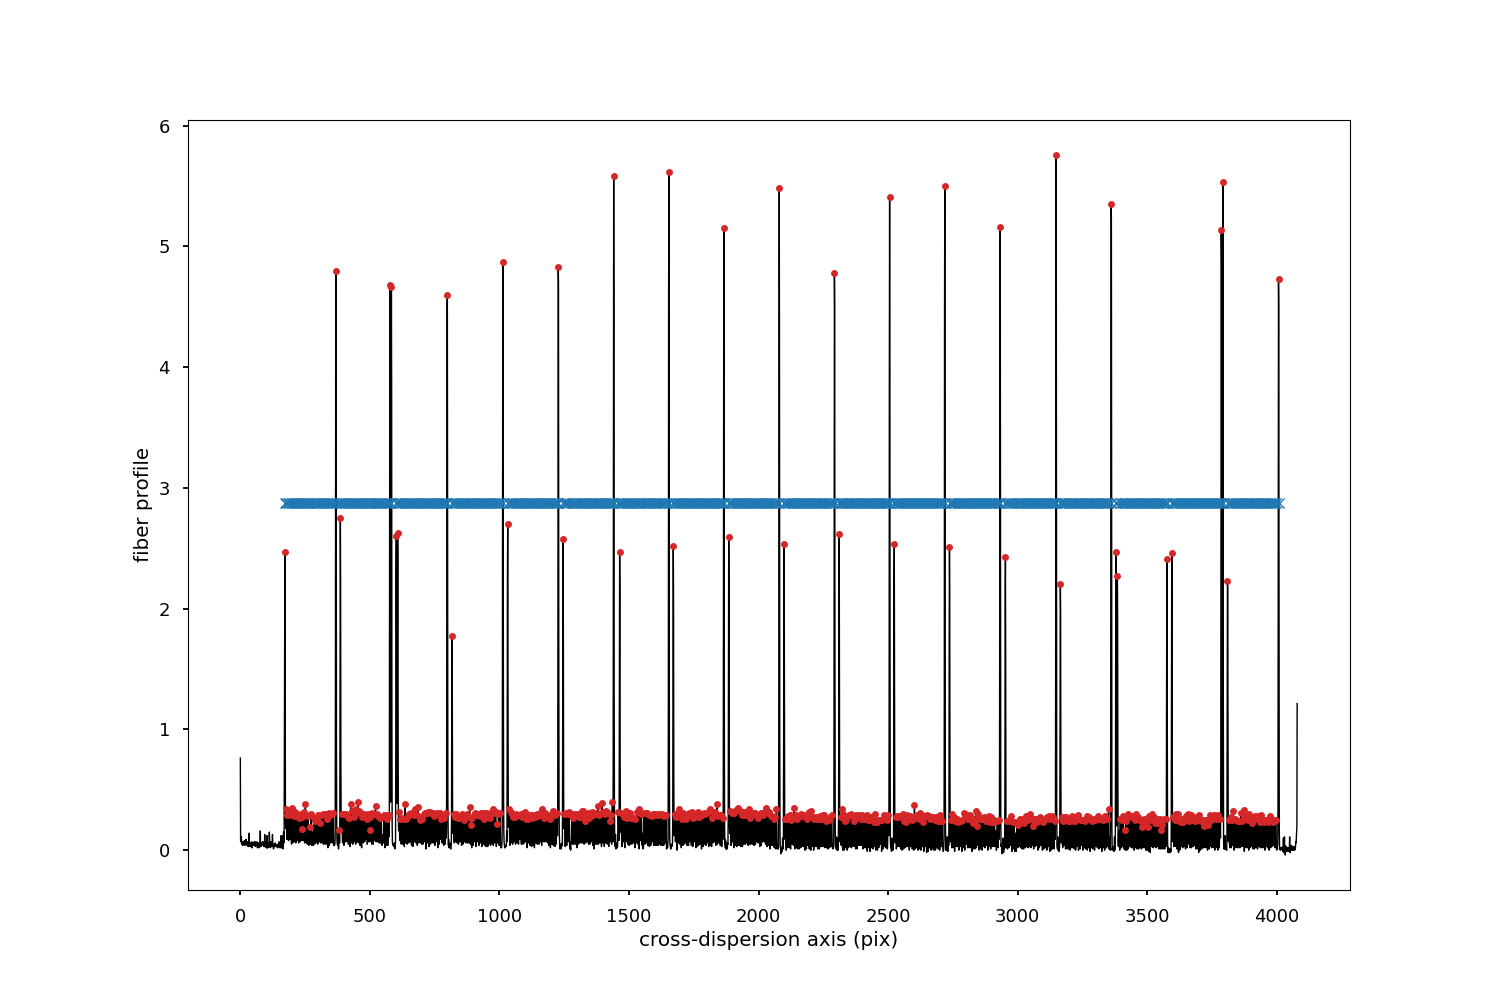

mjd                                          super
kind                                    mfiberflat
camera                                          b2
exptime                                        270
path       ./data/lvm-super-mfiberflat-b2-270.fits
Name: 6, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


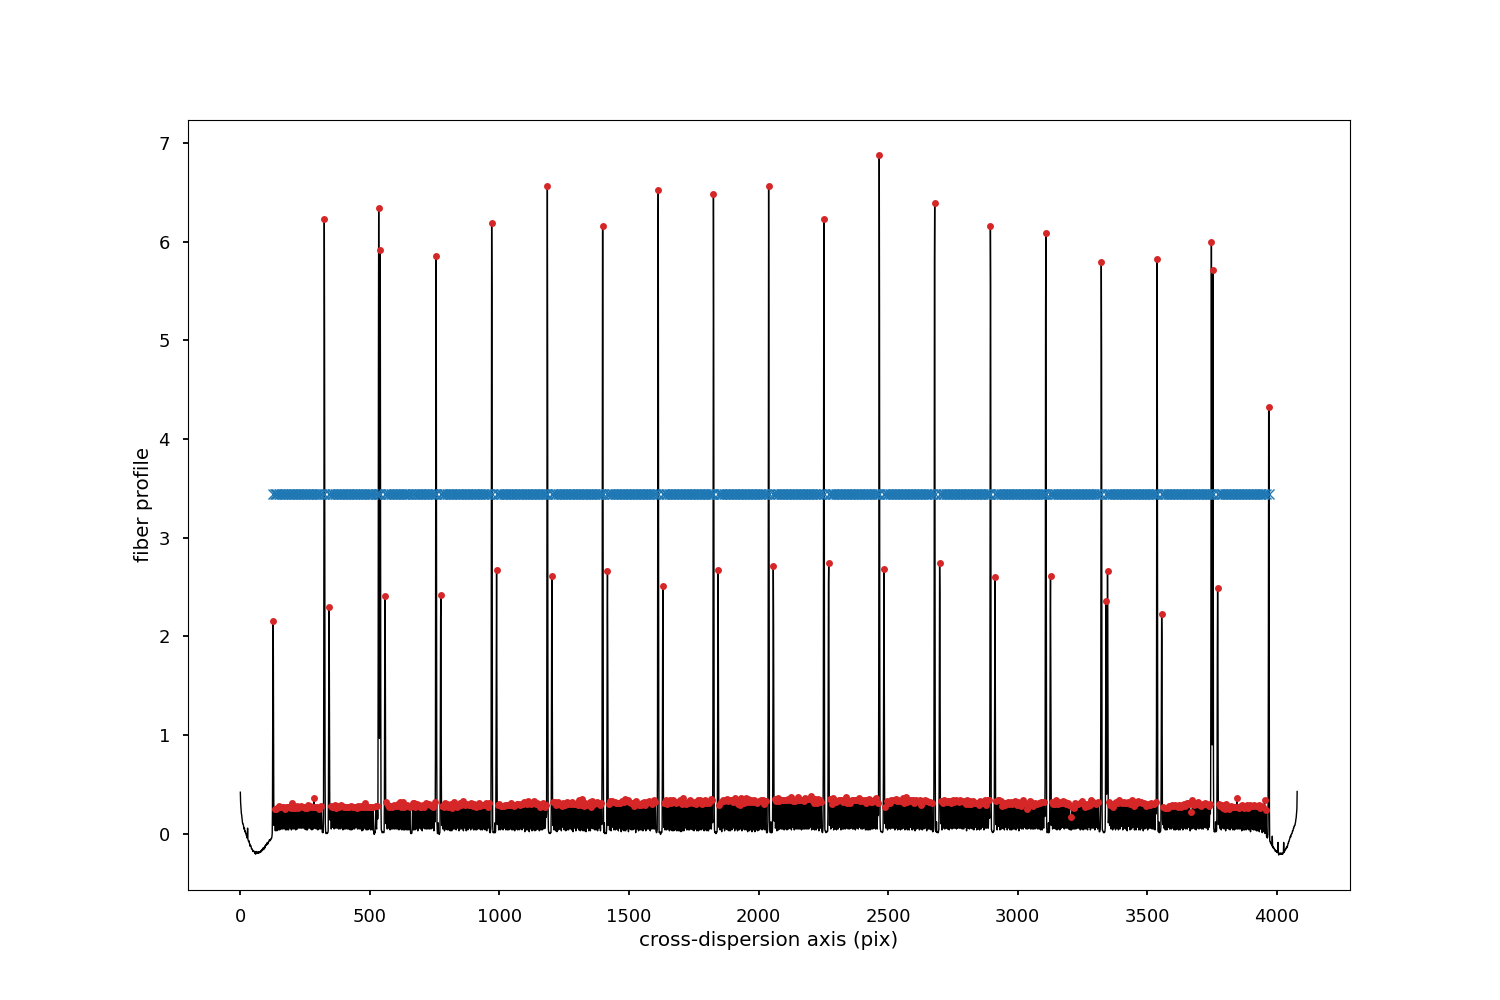

mjd                                         super
kind                                   mfiberflat
camera                                         b3
exptime                                        10
path       ./data/lvm-super-mfiberflat-b3-10.fits
Name: 8, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


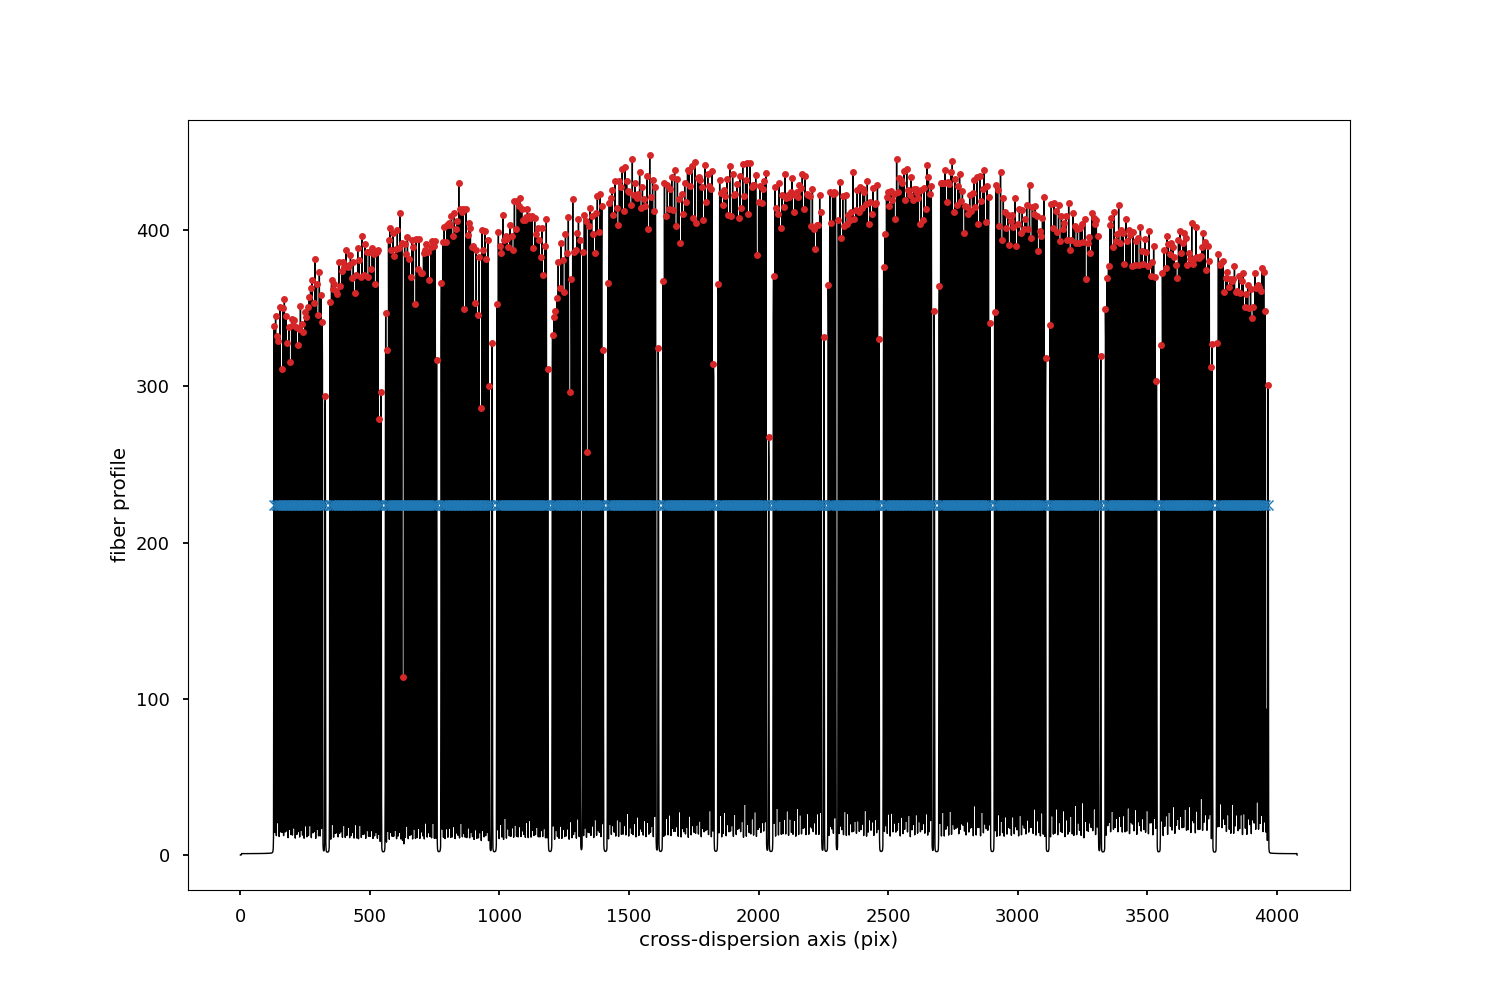

mjd                                         super
kind                                   mfiberflat
camera                                         r1
exptime                                        30
path       ./data/lvm-super-mfiberflat-r1-30.fits
Name: 4, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


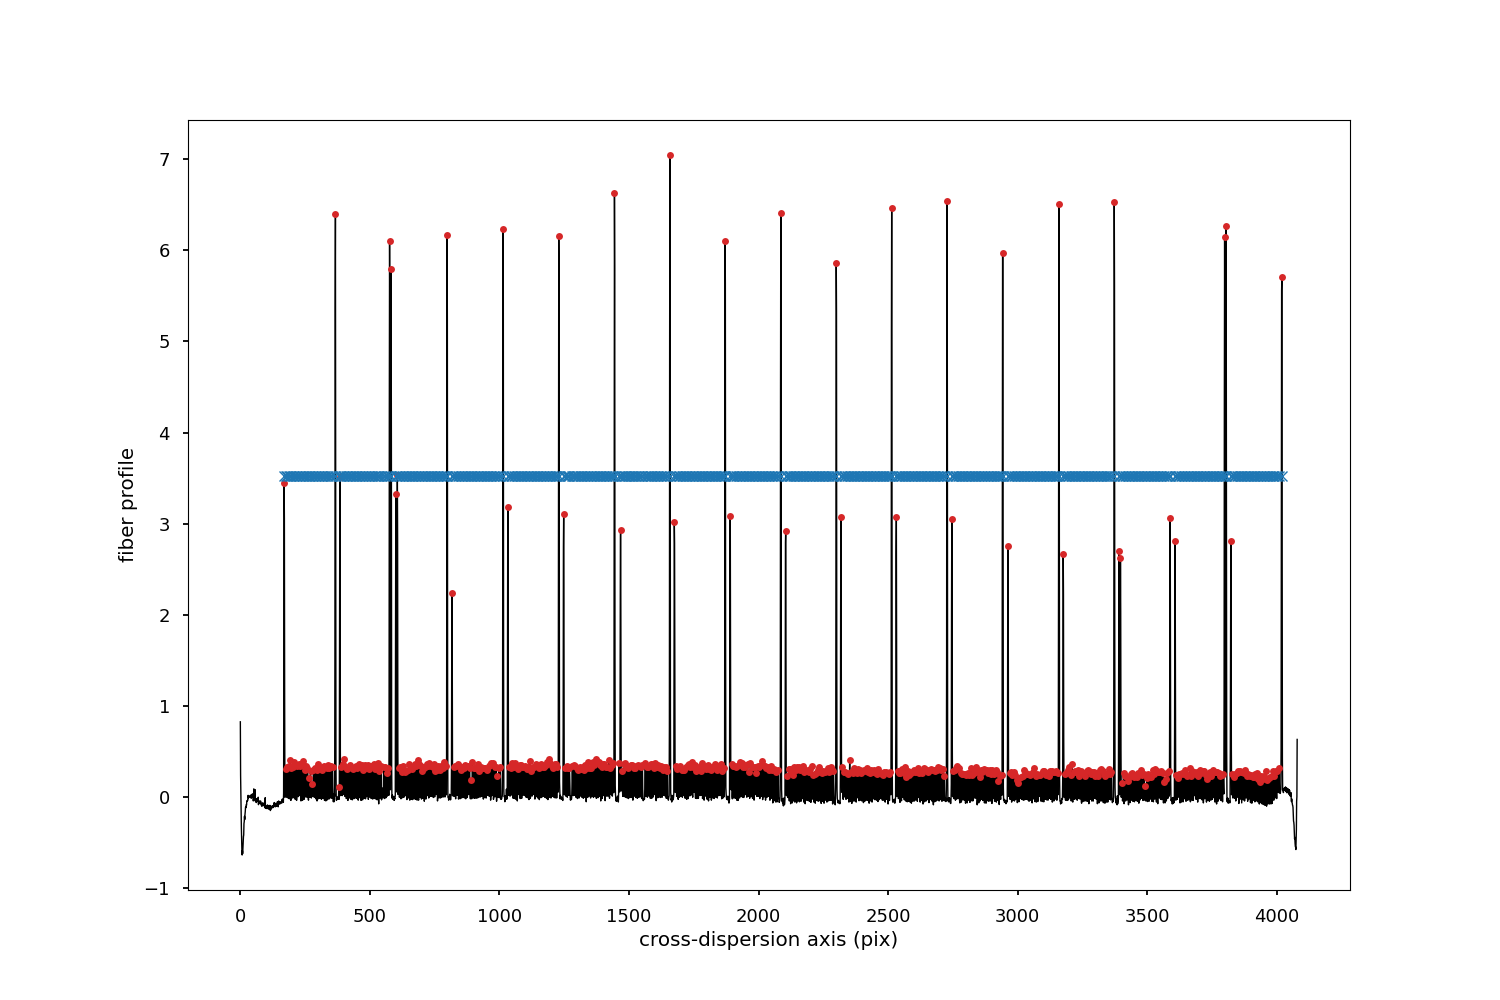

mjd                                          super
kind                                    mfiberflat
camera                                          r2
exptime                                        270
path       ./data/lvm-super-mfiberflat-r2-270.fits
Name: 2, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


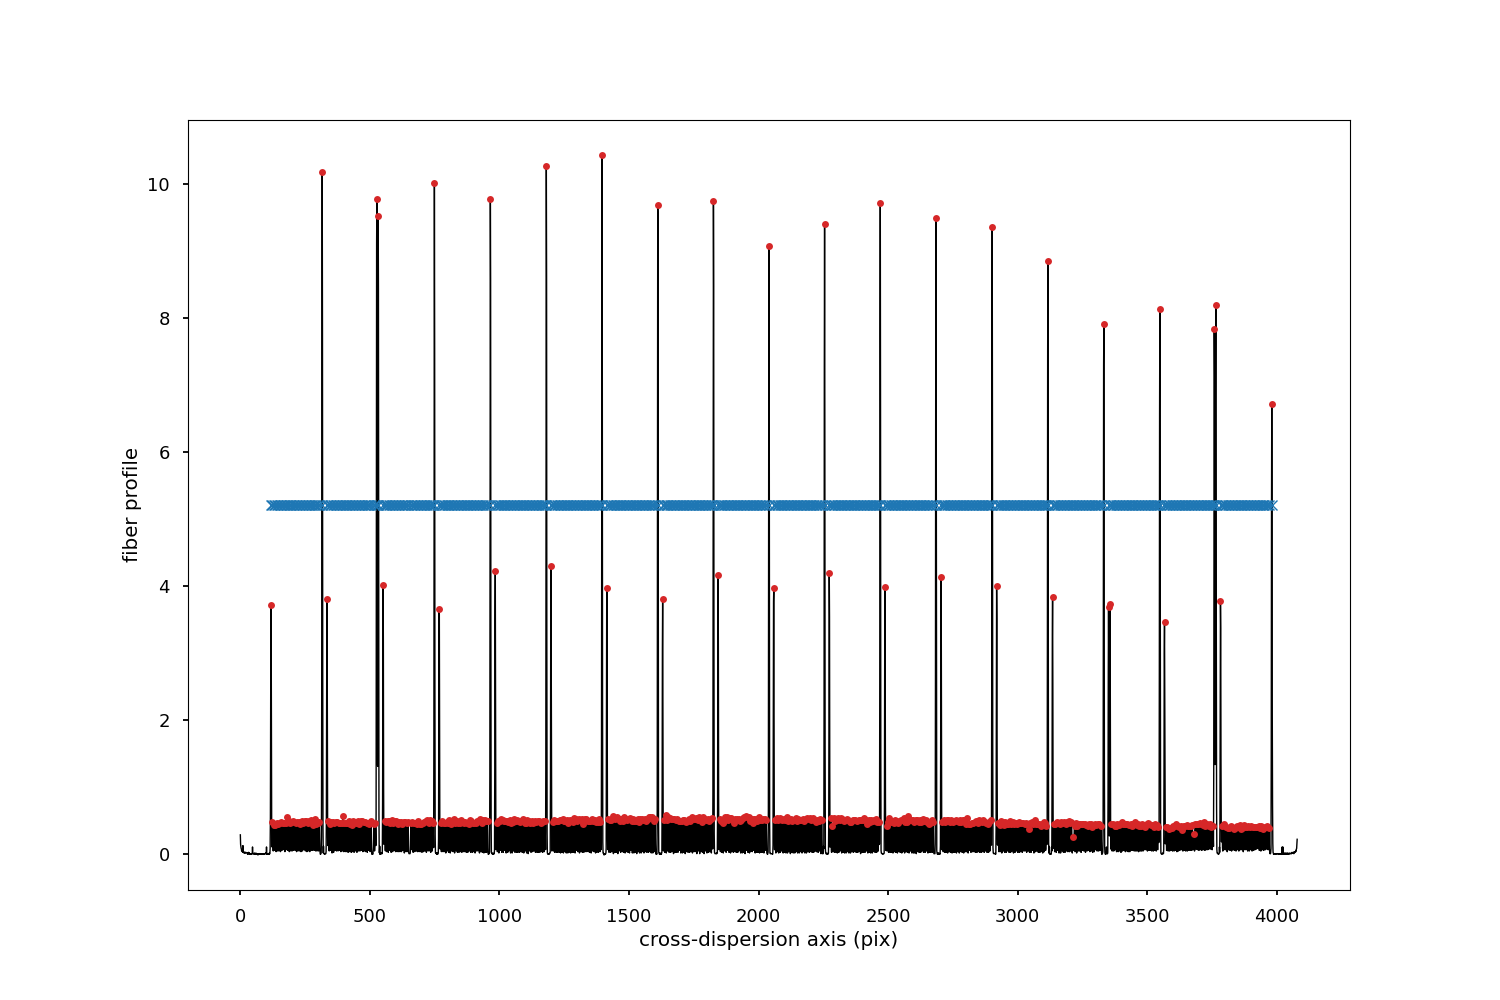

mjd                                         super
kind                                   mfiberflat
camera                                         r3
exptime                                        10
path       ./data/lvm-super-mfiberflat-r3-10.fits
Name: 3, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


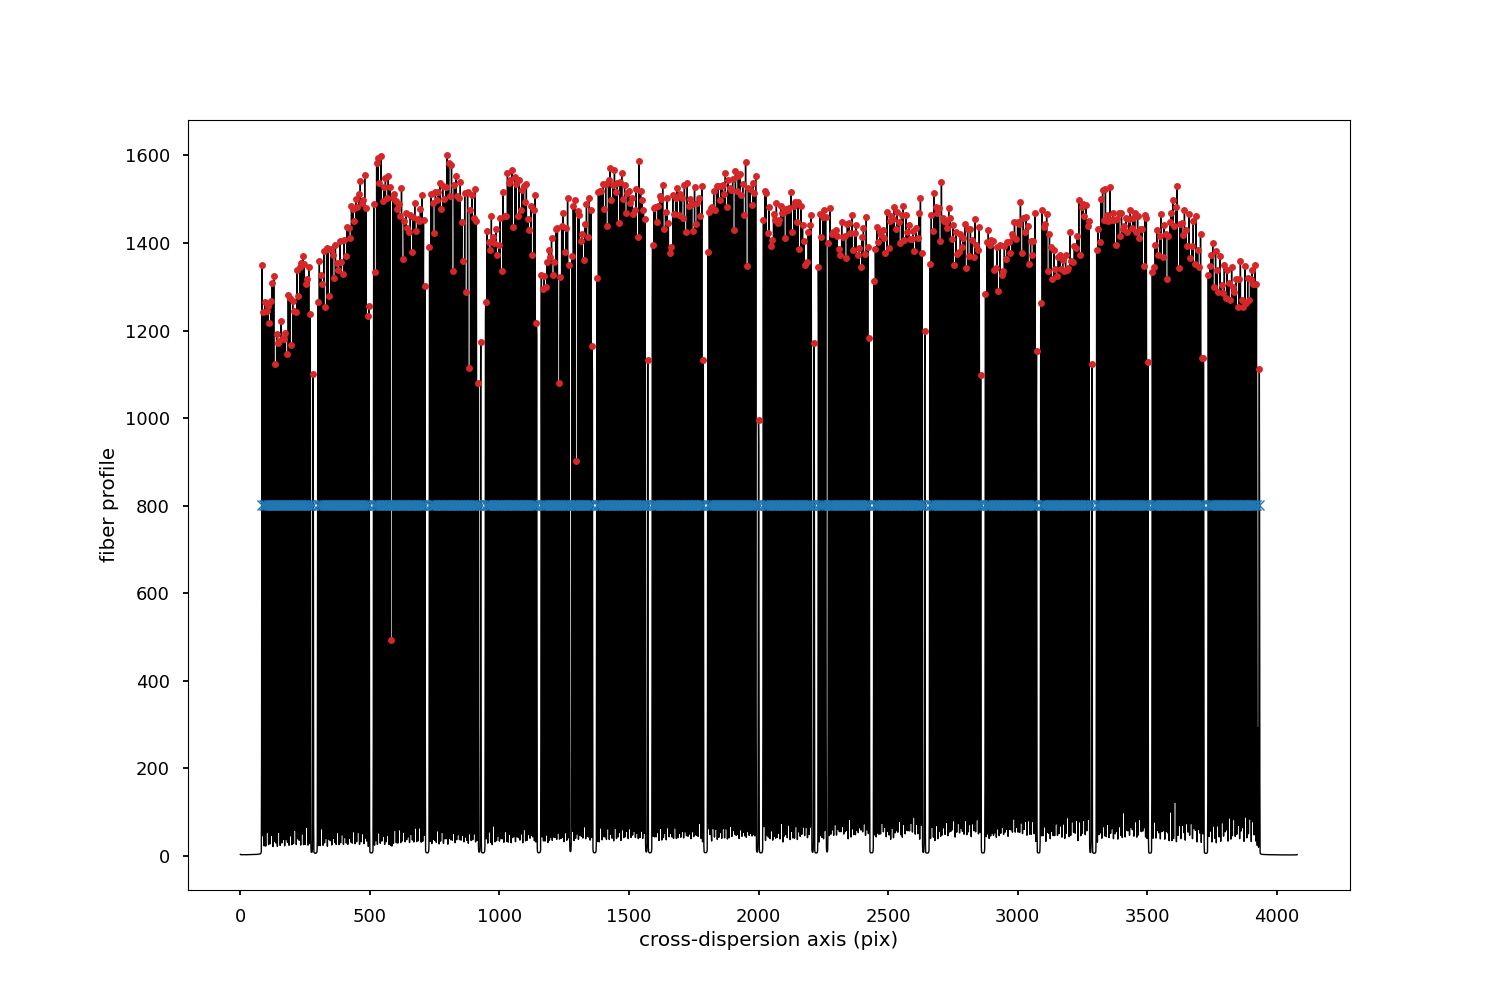

mjd                                         super
kind                                   mfiberflat
camera                                         z1
exptime                                        30
path       ./data/lvm-super-mfiberflat-z1-30.fits
Name: 5, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


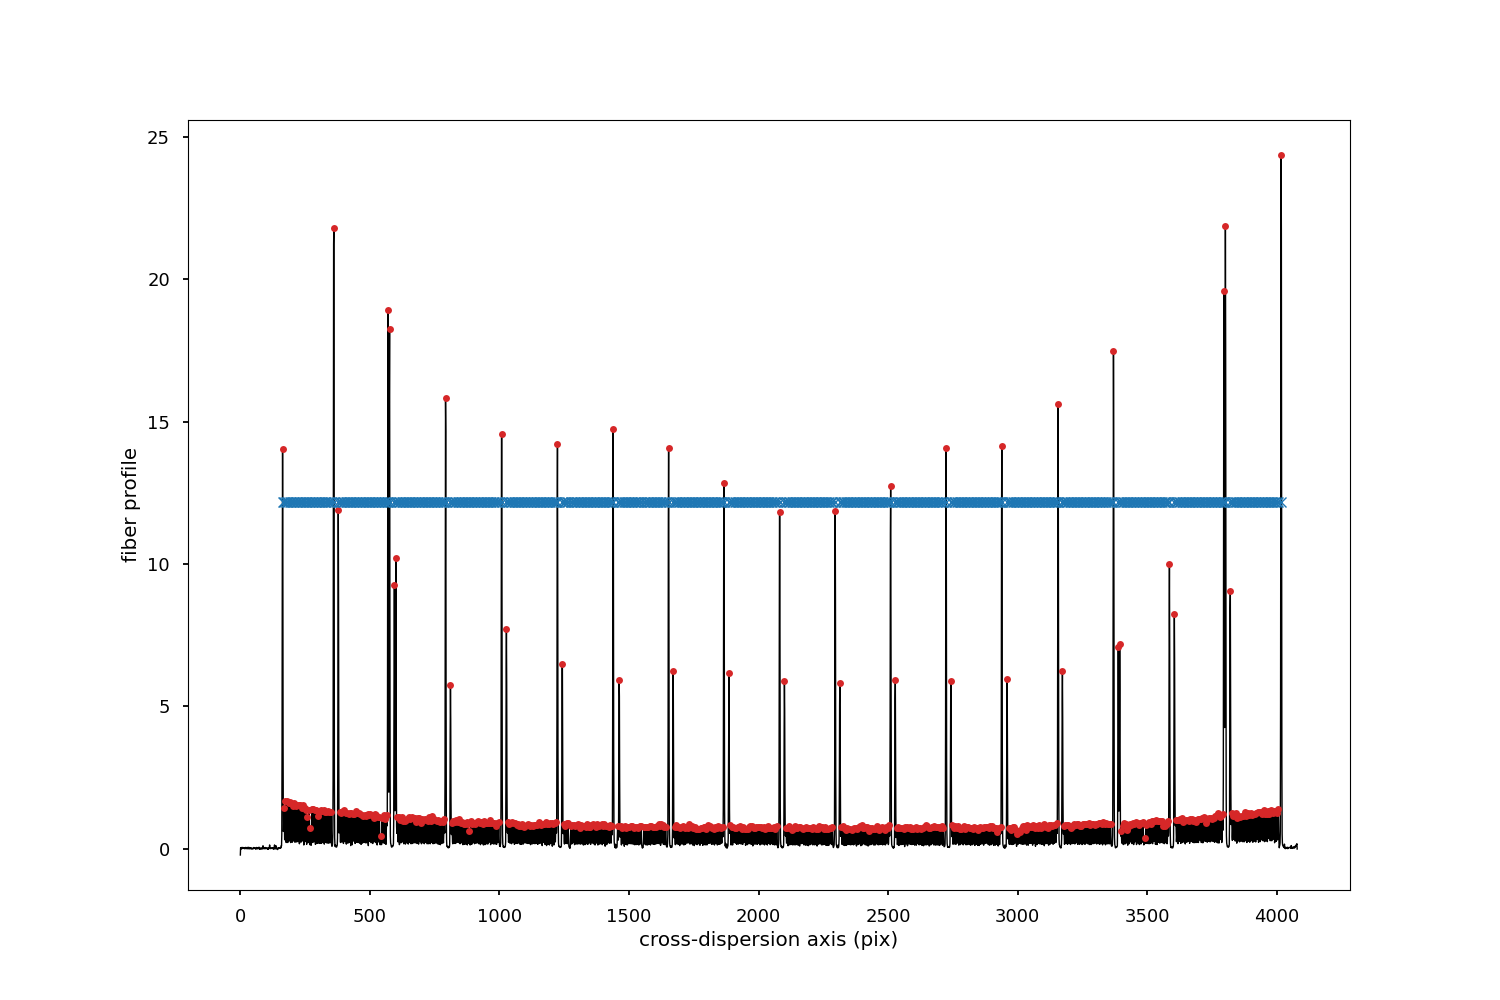

mjd                                          super
kind                                    mfiberflat
camera                                          z2
exptime                                        270
path       ./data/lvm-super-mfiberflat-z2-270.fits
Name: 7, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


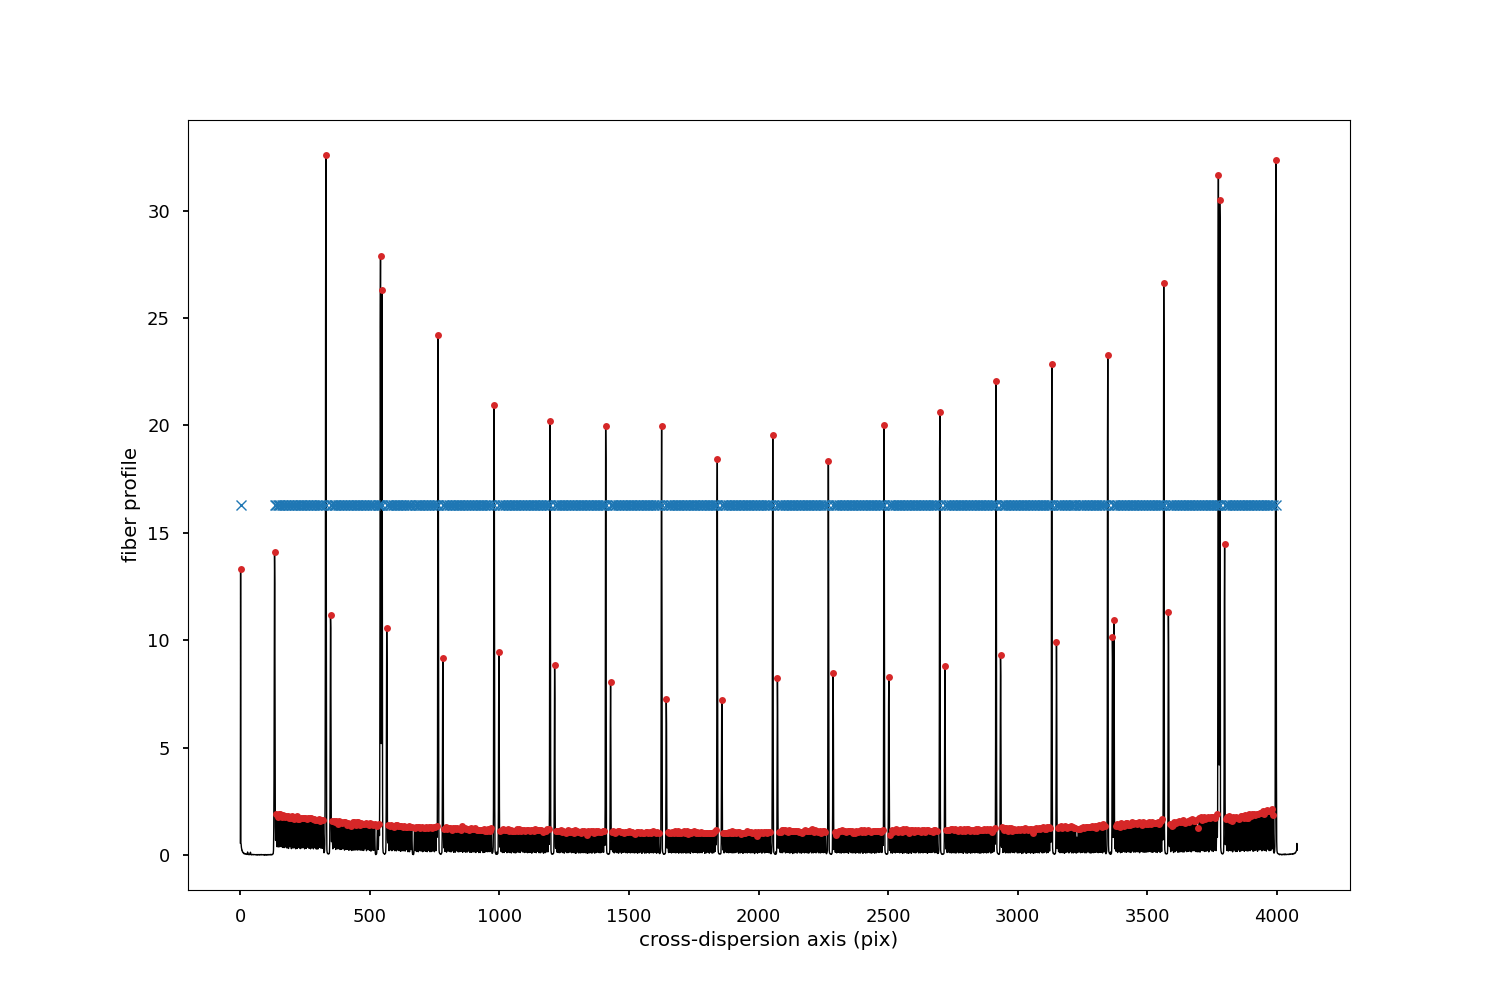

mjd                                         super
kind                                   mfiberflat
camera                                         z3
exptime                                        10
path       ./data/lvm-super-mfiberflat-z3-10.fits
Name: 0, dtype: object
[INFO]: selecting column = 3000 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


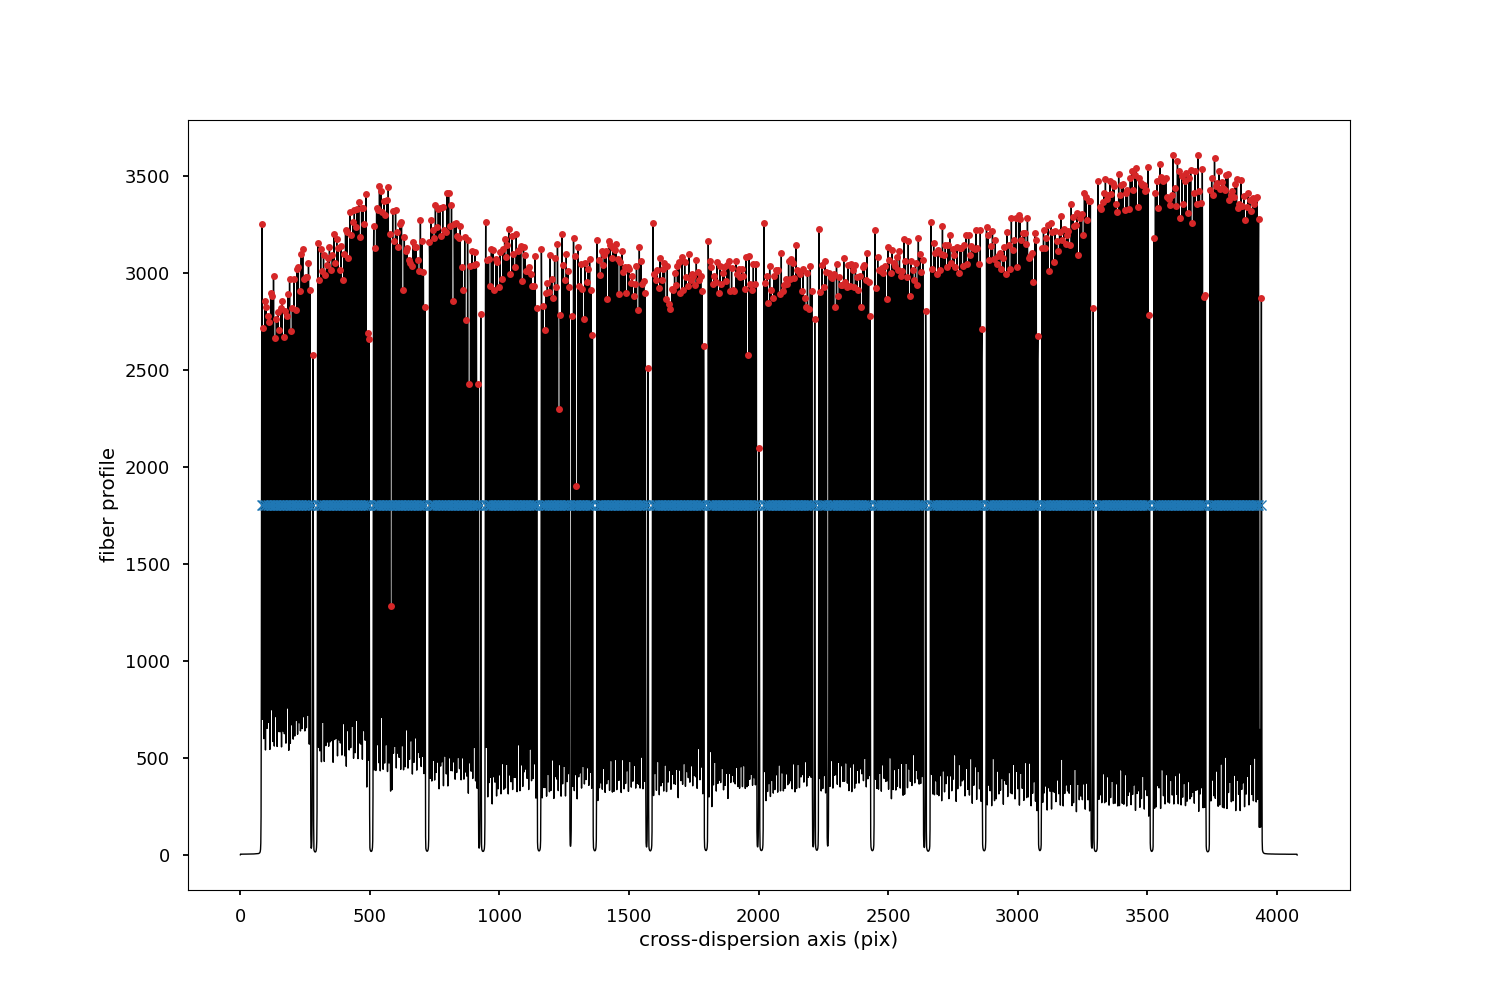

In [4]:
for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    
    try:
        imageMethod.findPeaksAuto_drp(
            in_image=mfiberflat.path,
            out_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=mfiberflat.exptime).replace(".fits", ".txt"),
            nfibers=638, slice=3000, threshold=0, method="hyperbolic", median_box=10, median_cross=1, display_plots=1
        )
    except ValueError:
        imageMethod.image_logger.error(f"error while detecting fibers in '{mfiberflat.path}'")
        continue

In [5]:
# avoid edges by one or two boxes before fitting the trace
for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    try:
        imageMethod.tracePeaks_drp(
            in_image=mfiberflat.path,
            out_trace=out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime),
            in_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime).replace(".fits", ".txt"),
            steps=30, coadd=1, threshold=0, max_diff=2, method="hyperbolic", median_box=10, median_cross=1, plot=1,
            poly_disp=2
        )
    except np.linalg.LinAlgError:
        imageMethod.image_logger.error(f"error while tracing fiberflat '{mfiberflat.path}'")
        continue

mjd                                         super
kind                                   mfiberflat
camera                                         b1
exptime                                        30
path       ./data/lvm-super-mfiberflat-b1-30.fits
Name: 1, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber left from pixel 3000:   4%|8                    | 127/3000 [00:00<00:02, 1266.72pixel/s]

[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: invalid value encountered in divide (RuntimeWarning)


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1269.71pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                          super
kind                                    mfiberflat
camera                                          b2
exptime                                        270
path       ./data/lvm-super-mfiberflat-b2-270.fits
Name: 6, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1266.35pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                         super
kind                                   mfiberflat
camera                                         b3
exptime                                        10
path       ./data/lvm-super-mfiberflat-b3-10.fits
Name: 8, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1314.95pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                         super
kind                                   mfiberflat
camera                                         r1
exptime                                        30
path       ./data/lvm-super-mfiberflat-r1-30.fits
Name: 4, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1304.41pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                          super
kind                                    mfiberflat
camera                                          r2
exptime                                        270
path       ./data/lvm-super-mfiberflat-r2-270.fits
Name: 2, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1321.83pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                         super
kind                                   mfiberflat
camera                                         r3
exptime                                        10
path       ./data/lvm-super-mfiberflat-r3-10.fits
Name: 3, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1310.61pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                         super
kind                                   mfiberflat
camera                                         z1
exptime                                        30
path       ./data/lvm-super-mfiberflat-z1-30.fits
Name: 5, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1275.27pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                          super
kind                                    mfiberflat
camera                                          z2
exptime                                        270
path       ./data/lvm-super-mfiberflat-z2-270.fits
Name: 7, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1228.64pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                         super
kind                                   mfiberflat
camera                                         z3
exptime                                        10
path       ./data/lvm-super-mfiberflat-z3-10.fits
Name: 0, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3000: 100%|###################| 1085/1085 [00:00<00:00, 1292.86pixel/s]


[INFO]: fitting trace with 2-deg polynomial


In [6]:
# from lvmdrp.core import tracemask
# from astropy.visualization import simple_norm

# trace_path = out_calib_path.format(mjd="super", kind="mtrace", camera="r2", exptime="x")

# trace = tracemask.TraceMask()
# trace.loadFitsData(trace_path)

# fiberflat = image.loadImage(trace_path.replace("mtrace", "mfiberflat"))

# fiberflat_data = fiberflat._data
# # fiberflat_data[fiberflat._mask] = np.nan

# norm = simple_norm(fiberflat_data, stretch="log", max_percent=95)
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(fiberflat_data, norm=norm, origin="lower", cmap="binary_r")

# for ifiber in range(trace._fibers):
#     fiber = trace.getSpec(ifiber)
#     ax.plot(fiber._pixels, fiber._data, color=plt.cm.rainbow(ifiber/trace._fibers), lw=1)

In [7]:
# trace._pixels[[0,-1]]

In [8]:
# peaks = np.loadtxt("data/lvm-super-mpeaks-r2-x.txt", skiprows=1)
# peaks

In [9]:
# plt.figure(figsize=(20,5))
# plt.plot(peaks[:,2], np.zeros_like(peaks[:,0]), ".")

In [10]:
# from np.polynomial import Polynomial

# # poly = Polynomial(trace._coeffs[0], domain=trace._pixels[[0-1]].tolist())

# # poly(trace._pixels), trace._data

# plt.figure(figsize=(20,5))

# icoef = 0
# mlinear = Polynomial.fit(peaks[:,2], trace._coeffs[:, icoef], deg=1)
# plt.plot(peaks[:,2], trace._coeffs[:, icoef] - peaks[:,2], ".")


In [11]:
master_traces = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mtrace", exptime="x")
print(master_traces.to_string())

for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    master_trace = master_traces.query("camera==@mfiberflat.camera")
    try:
        mtrace = master_trace.iloc[0]
    except:
        imageMethod.image_logger.error(f"no master trace found for '{mfiberflat.path}'")
        continue
    
    imageMethod.extractSpec_drp(
        in_image=mfiberflat.path,
        out_rss=out_calib_path.format(mjd=mfiberflat.mjd, kind="xfiberflat", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime),
        in_trace=mtrace.path,
        method="aperture", aperture=4, plot=1, parallel="auto"
    )

     mjd    kind camera exptime                               path
0  super  mtrace     b1       x  ./data/lvm-super-mtrace-b1-x.fits
1  super  mtrace     z3       x  ./data/lvm-super-mtrace-z3-x.fits
2  super  mtrace     r1       x  ./data/lvm-super-mtrace-r1-x.fits
3  super  mtrace     z2       x  ./data/lvm-super-mtrace-z2-x.fits
4  super  mtrace     b2       x  ./data/lvm-super-mtrace-b2-x.fits
5  super  mtrace     b3       x  ./data/lvm-super-mtrace-b3-x.fits
6  super  mtrace     z1       x  ./data/lvm-super-mtrace-z1-x.fits
7  super  mtrace     r3       x  ./data/lvm-super-mtrace-r3-x.fits
8  super  mtrace     r2       x  ./data/lvm-super-mtrace-r2-x.fits
mjd                                         super
kind                                   mfiberflat
camera                                         b1
exptime                                        30
path       ./data/lvm-super-mfiberflat-b1-30.fits
Name: 1, dtype: object
mjd                                          super
kind  